In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
from datetime import datetime as dt
import time
import csv
import requests
import urllib.parse

import json

In [2]:
rawGames = pd.read_csv('SteamAppsInfo.csv', encoding = "ISO-8859-1")

In [3]:
rawGames

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
0,1688200,War Of Gold,"Tero Lunkka,Valkeala Software","Aug 22, 2021",0.59,15.0,66%,"['Action', 'Casual', 'Indie']","['Casual', 'Action', '3D Fighter', 'Shooter', ...",All Games,False,You super hero soldier need save robber gold b...,False
1,1688210,Utopia,Iconic Ideaz,"Jan 7, 2022",NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","['Early Access', 'RPG', 'Survival', 'Colorful'...",All Games,False,UTOPIA is an open world survival game set in a...,False
2,1688220,Fire & Reign,Siphon Shock,Jun 2022,NaN,NaN,NaN,"['Action', 'Indie']","['Bullet Hell', 'Action', ""Shoot 'Em Up"", 'Sho...",All Games,False,Upgrade your warriors and shoot through waves ...,False
3,1688240,Escape from the Office,"ParachuteGames, ImperiumGame","Jul 26, 2021",2.99,12.0,91%,"['Action', 'Indie']","['Action', 'Precision Platformer', 'Perma Deat...",All Games,False,Escape from the Office is a 2D side-scrolling ...,False
4,1688250,PRINCESS IN AIRINESS,Broken Desk,"Jul 26, 2021",3.99,2.0,NaN,"['Action', 'Indie']","['Action', 'Point & Click', '2D Platformer', '...",All Games,False,"To pray for peace, the princess once again fli...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113005,1972180,Dub Club,Cyberfunk Studios LLC,"May 20, 2022",0.00,NaN,NaN,"['Casual', 'Free to Play']","['Casual', 'Rhythm', 'Exploration', 'Third Per...",All Games,False,A third person multiplayer virtual music venue...,False
113006,1595760,ScreenSpace,Wave Project,"Apr 23, 2021",1.99,1.0,NaN,"['Casual', 'Indie']","['Casual', 'Clicker', 'Arcade', 'Point & Click...",All Games,False,Test your focus and reflexes in this simplisti...,False
113007,1996680,Fowl Scourge,Void Cup Games,When its done,NaN,NaN,NaN,"['Action', 'Indie', 'RPG']",[],All Games,False,In this Dark Fantasy Action-RPG you are part o...,False
113008,1972250,Project: Maidenless,Grossly Incandescent Games,TBA,NaN,NaN,NaN,"['Action', 'Adventure', 'Indie', 'Massively Mu...","['Early Access', 'Action', 'Adventure', 'RPG',...",All Games,False,Scavenge for loot in an unforgiving world fill...,False


In [4]:
len(rawGames['appId'].to_list())

113010

In [5]:
#Now to try and get the dates.
#
#Note that this script eliminates dates which don't fit certain date formats.
#
#For example, it converts "Coming Soon" to NaN.
def datesCleaned(dataframe):
    
    datesCleaned = [];
    
    #Convert to dt format
    for i in dataframe['releaseDate']:
        try:
            datesCleaned.append(dt.strptime(i, '%b %d, %Y'))
        except:
            try:
                datesCleaned.append(dt.strptime(i, '%b, %Y'))
                
            except:
                try: datesCleaned.append(dt.strptime(i, '%b %Y'))
                    
                except:
                    datesCleaned.append(np.nan)
            
    datesCleanedSeries = pd.Series(datesCleaned)
    
    datesCleanedSeries.index = dataframe.index
    
    return datesCleanedSeries

datesCleaned = datesCleaned(rawGames)

#Replece release dates with cleaned dates
rawGames['releaseDate'] = datesCleaned
        
# #Add cleaned release dates to dataframes
# ncrpgs_df['releaseDate'] = rpgDatesCleaned[ncrpgs_df.index]
# crpgs_df['releaseDate'] = rpgDatesCleaned[crpgs_df.index]

In [6]:
#Clean all the game tags
def tagsCleaned(games):
    
    tagsCleaned = []
    
    for k in games.index:
        
        #Get rid of \' \s \em etc.
        tagsRemovedSlashes = re.findall(r"'(.*?)'[,\]]",games.tagsList[k]\
                                        .replace("\'s","s").replace("\'em","em")\
                                        .replace("\'Em","Em").replace("\'","''"))
        
        tagsCleaned.append([tagsRemovedSlashes[j].replace("'","") for j in range(len(tagsRemovedSlashes))])
        
    tagsCleanedSeries = pd.Series(tagsCleaned)
    
    tagsCleanedSeries.index = games.index
        
    return tagsCleanedSeries

rawGames['tagsList'] = tagsCleaned(rawGames)

print(rawGames['tagsList'][0])

['Casual', 'Action', '3D Fighter', 'Shooter', 'Runner', 'Real Time Tactics', 'Hero Shooter', '3D', 'Military', 'Stealth', 'Flight', 'Survival', 'Story Rich', 'Combat', 'Singleplayer', 'Third-Person Shooter', 'Vehicular Combat', 'Indie', 'First-Person', 'Character Customization']


In [7]:
#Find all non-DLC RPGs and CRPGs
rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])
                 for i in range(len(rawGames))]][rawGames['dlcBool'] == False]

C:\Users\phyis\AppData\Local\Temp\ipykernel_33964\183280176.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])


In [9]:
def tagBool(games,tagNames):
    
    #Check for a tag name in every game in dataframe
    tagBoolSeries = pd.Series([any([tagName in games['tagsList'][j] for tagName in tagNames]) for j in games.index])
    
    tagBoolSeries.index = games.index
    return tagBoolSeries

#Get list of Booleans corresponding to whether the game is a CRPG
crpgBool = tagBool(rpgs, ['CRPG'])

In [10]:
#All CRPGs
crpgs_df = rpgs.copy()[crpgBool.tolist()]

#All non-CRPG RPGs (nCRPGs)
ncrpgs_df = rpgs.copy()[np.logical_not(crpgBool.tolist())]

In [11]:
any([True,False])

True

In [12]:
ncrpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
1,1688210,Utopia,Iconic Ideaz,2022-01-07,NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","[Early Access, RPG, Survival, Colorful, Base B...",All Games,False,UTOPIA is an open world survival game set in a...,False
8,1688320,OneBit Adventure,"Galactic Slice, LLC",2022-08-05,0.00,NaN,NaN,"['Adventure', 'Casual', 'Free to Play', 'Indie...","[Roguelite, Roguelike, Class-Based, Dungeon Cr...",All Games,False,OneBit Adventure is a casual turn-based roguel...,False
26,1688600,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
27,1688630,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
28,1688640,Cleanup on Isle Goblin,Kilowatt Games,NaT,NaN,NaN,NaN,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Life Sim, RPG, Pixel Graphics, Adventure, Cra...",All Games,False,Isle Goblin has been invaded by destructive hu...,False


In [13]:
crpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
218,1686130,Deep Despair 2,BekkerDev Studio,2021-10-08,6.99,67.0,88%,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Sandbox, Crafting, Adventure, Survival, Simul...",All Games,False,Deep Despair 2 is an open world survival adven...,False
458,1684240,Metal Faith,Youth Game,2021-08-02,9.99,NaN,NaN,"['Adventure', 'Indie', 'RPG']","[Adventure, RPG, Action-Adventure, Shooter, Pu...",All Games,False,A 3D adventure puzzle game,False
459,1684250,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
464,1684310,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
479,1683870,Crystalreach Islands,Majao Games,NaT,NaN,NaN,NaN,['RPG'],"[RPG, Fantasy, Action RPG, Open World, Sandbox...",All Games,False,Crystalreach Islands is an open-world action R...,False


In [14]:
rpgs.tagsList.replace("\'s","s").replace("\'em","em").replace("\'Em","Em").replace("\'","''")

1         [Early Access, RPG, Survival, Colorful, Base B...
8         [Roguelite, Roguelike, Class-Based, Dungeon Cr...
26        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
27        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
28        [Life Sim, RPG, Pixel Graphics, Adventure, Cra...
                                ...                        
112994    [Casual, Adventure, RPG, JRPG, Turn-Based Tact...
112995    [RPG, Action RPG, 2D Platformer, Pixel Graphic...
113003    [Strategy, Grand Strategy, Turn-Based Strategy...
113004    [Action, RPG, 2D Fighter, 3D Fighter, JRPG, 3D...
113008    [Early Access, Action, Adventure, RPG, Action ...
Name: tagsList, Length: 15689, dtype: object

In [8]:
rpgDates = datesCleaned[rpgs.index]

In [1078]:
#Count number of games over the years
def gameGrowth(games,start_date):
    end_date = dt.now().year

    dates = range(start_date,end_date+1)

    gamesCount=[]
    for date in dates:
        #How many games were released before "date"?
        gamesCount.append(len(games[[games['releaseDate'][i].year < date for i in games.index]].index))
        
    return gamesCount

In [17]:
array = [['a','b'], ['a', 'b','c'], ['a']]
result = {x for l in array for x in l}
print(result)

{'b', 'a', 'c'}


In [18]:
#Get game developer location data
gameDevLocations = pd.read_csv('GameDevLocations.csv',skip_blank_lines=True).dropna()

In [19]:
gameDevLocations.head()

,company,city,state/province,country,alteredTextBool
1,0verflow,Tokyo,Tokyo,Japan,False
3,1 Simple Game,Zapopan,Jalisco,Mexico,False
5,100 Stones Interactive,Brisbane,Queensland,Australia,False
7,1047 Games,Zephyr Cove,Nevada,United States,False
9,10tons,Tampere,Tavastia,Finland,False


In [613]:
def intersection(list1, list2):
    list3 = [value for value in list1 if value in list2]
    return list3

intersection(['all','or','nothing'],['all','nothing'])

['all', 'nothing']

In [118]:
#Split location names into lists of strings to compare between datasets

import re

def locationSplitter(string):
    strings = re.split(r',| |-', string)

    unwantedStrings = ['', 'And', 'The', 'Games', 'Studios', 'Studio', 'Game', 'Games',\
                           'and', 'the', 'games', 'studios', 'studio', 'game', 'games']
    
    newStrings = [i for i in strings if i not in unwantedStrings]
    
    return newStrings

In [119]:
#Get lists of split game developer name strings from each dataset

steamGameDevLocationsSplit = [];
gameDevLocationsSplit = []

for string in rawGames.developerName.tolist():
    
    try:
        steamGameDevLocationsSplit.append(locationSplitter(string))
        
    except TypeError:
        steamGameDevLocationsSplit.append(np.nan)
        pass
    
for string in gameDevLocations.company.tolist():
    
    try:
        gameDevLocationsSplit.append(locationSplitter(string))
        
    except TypeError:
        gameDevLocationsSplit.append(np.nan)
        pass

In [154]:
gameDevLocations.reset_index().loc[0]

index                     1
company            0verflow
city                  Tokyo
state/province        Tokyo
country               Japan
alteredTextBool       False
Name: 0, dtype: object

In [186]:
#Create empty lists to fill with info about game developer locations
gameDevNamesList = [];
gameDevCityList = [];
gameDevStateProvinceList = [];
gameDevCountryList = [];

for steamDevNameWords in steamGameDevLocationsSplit:
    
    loop = 0
    
    for gameDevNameWords in gameDevLocationsSplit:
        
        try:
            if len(intersection(steamDevNameWords, gameDevNameWords))/len(steamDevNameWords) >= 0.75:

                locationIndex = gameDevLocationsSplit.index(gameDevNameWords)

                gameDev = gameDevLocations.reset_index().loc[locationIndex]

                gameDevNamesList.append(gameDev[1])
                gameDevCityList.append(gameDev[2])
                gameDevStateProvinceList.append(gameDev[3])
                gameDevCountryList.append(gameDev[4])

                pass
            
        except (ZeroDivisionError, TypeError):
            pass
        
        loop += 1
        
    if loop == len(gameDevLocationsSplit):
        gameDevNamesList.append(np.nan)
        gameDevCityList.append(np.nan)
        gameDevStateProvinceList.append(np.nan)
        gameDevCountryList.append(np.nan)

In [173]:
gameDevStateProvinceList.count(np.nan)/len(gameDevStateProvinceList)

0.854498574701519

In [189]:
gameDevStateProvinceList.count(np.nan)

19569

In [20]:
# #Add developer location to rawGames
# gameDevCityList = [];
# gameDevStateProvinceList = [];
# gameDevCountryList = [];
# for i in range(len(rawGames)):
#     if rawGames.loc[i].developerName in gameDevLocations.company.tolist():
        
#         gameDev = gameDevLocations[gameDevLocations.company == rawGames.loc[i].developerName]
        
#         gameDevCityList.append([gameDev.loc[j][1] for j in gameDev.index])
#         gameDevStateProvinceList.append([gameDev.loc[j][2] for j in gameDev.index])
#         gameDevCountryList.append([gameDev.loc[j][3] for j in gameDev.index])
        
#     else:
#         gameDevCityList.append([np.nan])
#         gameDevStateProvinceList.append([np.nan])
#         gameDevCountryList.append([np.nan])

In [21]:
gameDevCountryList.count([np.nan])/len(gameDevCountryList)

0.9243695248208124

In [22]:
len(rawGames.developerName.unique())

43280

In [219]:
address = 'St. Catherines, Ontario, Canada'
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
print(response[0]["lat"])
print(response[0]["lon"])


IndexError: list index out of range

In [225]:
len(gameDevCountryList)

132579

In [227]:
100%10

0

In [279]:
#Check if we already have a csv file containing game dev lat/long coordinates
if exists('coordinates.csv'):
    gamesTimeSeries = pd.read_csv('coordinates.csv')
    print('Coordinates data already exists.')

#If not, get the coordinates by querying nominatim.openstreetmap.org with the city/state/country of the game devs
else:    
    latitudes = [];
    longitudes = [];

    startTime = time.time()
    
    for i in range(len(gameDevCountryList)):
        
        #Print progress every 1000 iterations
        if i%1000 == 0:
            print('{} iterations completed in {} seconds.'.format(i,time.time() - startTime))

        address = ''
        
        #Try to add the country, state/province, and city names to the query string
        if str(gameDevCountryList[i]) != 'nan':
            address = gameDevCountryList[i]

        if str(gameDevStateProvinceList[i]) != 'nan':
            address = gameDevStateProvinceList[i] + ', ' + address

        if str(gameDevCityList[i]) != 'nan':
            address += gameDevCityList[i] + ', ' + address
        
        #If we don't have any location information, append NaN to the lists
        if address == '':
            latitudes.append(np.nan)
            longitudes.append(np.nan)
        
        #Otherwise, ask for the coordinates and append them to the lists
        else:
            address = '{}, {}, {}'.format(gameDevCityList[i],gameDevStateProvinceList[i],gameDevCountryList[i])
            url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

            response = requests.get(url).json()

            try:
                latitudes.append(response[0]["lat"])
                longitudes.append(response[0]["lon"])

            except IndexError:
                latitudes.append(np.nan)
                longitudes.append(np.nan)
    
    #Cache this information so we don't need to run this twice!
    csvFile = open('coordinates.csv', 'w+')

    writer = csv.writer(csvFile, lineterminator = '\n')

    writer.writerow(['Latitudes','Longitudes'])
    
    for latitude,longitude in zip(latitudes,longitudes):
        writer.writerow([latitude,longitude])

    csvFile.close()

Coordinates data already exists.


In [239]:
csvFile = open('latitudes.csv', 'w+')

writer = csv.writer(csvFile, lineterminator = '\n')

for latitude in latitudes:
    writer.writerow([latitude])

csvFile.close()

In [276]:
latitudes = [np.nan]+pd.read_csv('latitudes.csv')['nan'].tolist()
longitudes = [np.nan]+pd.read_csv('longitudes.csv')['nan'].tolist()

In [277]:
csvFile = open('coordinates.csv', 'w+')

writer = csv.writer(csvFile, lineterminator = '\n')

writer.writerow(['Latitudes','Longitudes'])

for latitude,longitude in zip(latitudes,longitudes):
    writer.writerow([latitude,longitude])

csvFile.close()

In [278]:
coordinates = pd.read_csv('coordinates.csv')
coordinates.head()

,Latitudes,Longitudes
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


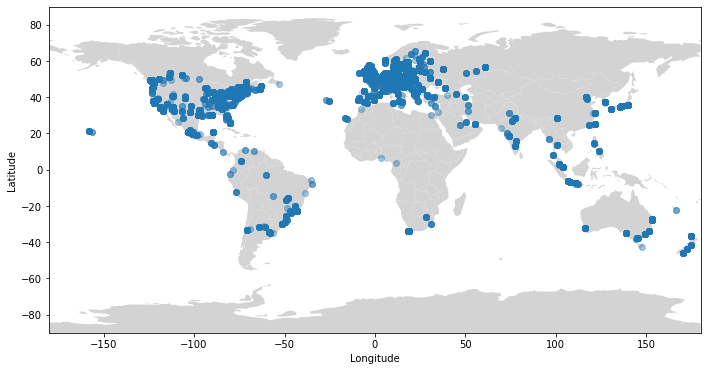

In [306]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

df = pd.read_csv('coordinates.csv')

#Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

#Plot game dev locations
Longitudes = df['Longitudes']
Latitudes = df['Latitudes']
plt.scatter(x, y, alpha=0.4, vmin=0, cmap='autumn')

#Creating axis limits
plt.xlim([-180, 180])
plt.ylim([-90, 90])


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

We now have a map of the game developers in the Steam games dataset whose locations we could find in the gameDevMap dataset. Now I want to combine this data with the original Steam games dataset and create visualizations of how the production of different game genres is distributed within countries around the world.

We can see from this plot that game production is heavily concentrated in the USA and Europe, so it would be somewhat uninteresting to plot the distribution, of say, RPG production, since it is likely to follow a similar distribution. What would be perhaps more interesting is to investigate what makes each country's game industry unique. To that end, I will create a map of countries which shows what genre is produced in that country more than any other genre when compared to the distribution across genres for all countries. In other words, I will label each country with the game genre in which that country "punches above its weight" to the greatest degree.

In [307]:
gameDevLocations

,company,city,state/province,country,alteredTextBool
1,0verflow,Tokyo,Tokyo,Japan,False
3,1 Simple Game,Zapopan,Jalisco,Mexico,False
5,100 Stones Interactive,Brisbane,Queensland,Australia,False
7,1047 Games,Zephyr Cove,Nevada,United States,False
9,10tons,Tampere,Tavastia,Finland,False
...,...,...,...,...,...
8153,Zwift,Long Beach,California,United States,False
8155,Zwift,Rio de Janeiro,Rio de Janeiro,Brazil,False
8157,Zynga Eugene,Eugene,Oregon,United States,False
8159,Zynga New York,New York City,New York,United States,False


# Plotting proportions of game genres
I am now going to make a little function that can generate plots of proportions of games of certain genres over time. This will provide an interesting visualization of how the Steam market for games has varied over time.

In [7]:
#Find number of games with each tag in every year since oldest game on Steam

from os.path import exists

startDate = min(rawGames['releaseDate']).year
endDate = dt.now().year

#All unique tag names
uniqueTagNames = pd.Series([j for i in range(len(rawGames.tagsList)) for j in rawGames.tagsList[i]]).unique()

startTime = time.time()

#Check if we have already created a .csv file of time series for all the game tags
if exists('SteamGamesTimeSeries.csv'):
    gamesTimeSeries = pd.read_csv('SteamGamesTimeSeries.csv')
    print('SteamGamesTimeSeries already exists.')

#If not, generate the time series for all game tags
else:
    timeSeriesCSV = open('SteamGamesTimeSeries.csv','w+')
    writer = csv.writer(timeSeriesCSV)
    writer.writerow(tuple(['tagName']+[i for i in range(startDate,endDate+1)]))
    
    for tag in uniqueTagNames:
        dates = range(startDate,endDate+1)

        gamesCount=[]
        for date in dates:
            #How many games with this tag were released before "date"?
            
            tagGames = rawGames[tagBool(rawGames,[tag])]

            gamesCount.append(len(tagGames[[tagGames['releaseDate'][i].year < date for i in tagGames.index]].index))
            
        writer.writerow(tuple([tag] + gamesCount))
        
    timeSeriesCSV.close()
    
print(time.time() - startTime)
            
        

    

SteamGamesTimeSeries already exists.
0.015651702880859375


In [26]:
allGamesCount = gameGrowth(rawGames,min(ncrpgs_df['releaseDate']).year)

In [27]:
ncrpgCount = gameGrowth(ncrpgs_df,min(ncrpgs_df['releaseDate']).year)

In [28]:
crpgCount = gameGrowth(crpgs_df,min(ncrpgs_df['releaseDate']).year)

In [32]:
tagTS = pd.read_csv('SteamGamesTimeSeries.csv',index_col=0)

In [1162]:
tagTS.shape

(423, 53)

In [1081]:
#Function to plot number of games with certain tags over time
def tagNumberPlot(tagNameList):
    plt.figure()

    #Define time range: oldest game on steam to current year
    startDate = min(rawGames['releaseDate']).year
    endDate = dt.now().year
    
    dates = range(startDate,endDate+1)
    
    #Plot all tag time series
    for tag in tagNameList:
        plt.plot(dates, tagTS.loc[tag].values, label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Number games')

    plt.grid()
    plt.legend()
    return

In [35]:
totalGamesCount = gameGrowth(rawGames,min(rawGames['releaseDate']).year)

In [1082]:
rawGames['releaseDate']

0        2021-08-22
1        2022-01-07
2        2022-06-01
3        2021-07-26
4        2021-07-26
            ...    
113005   2022-05-20
113006   2021-04-23
113007          NaT
113008          NaT
113009          NaT
Name: releaseDate, Length: 113010, dtype: datetime64[ns]

In [1106]:
#Function to plot proportion of games with certain tags over time
def tagProportionPlot(tagNameList,startDate=1970,endDate=2022):
    plt.figure()

    #Define time range: oldest game on steam to current year
    #
    #startDate = min(rawGames['releaseDate']).year
    #endDate = dt.now().year
    
    dates = range(startDate,endDate)
    
    #Plot all tag time series
    for tag in tagNameList:
        plt.plot(dates, [tagTS.loc[tag].values[i]/totalGamesCount[i] for i in np.arange(startDate-1970,endDate-1970)], label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Proportion of games')

    plt.grid()
    plt.legend()
    return

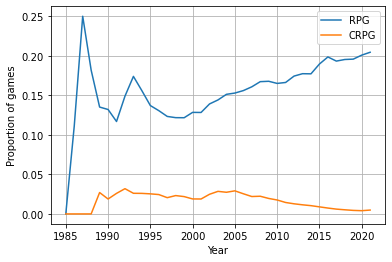

In [1112]:
tagProportionPlot(['RPG','CRPG'],startDate=1985)

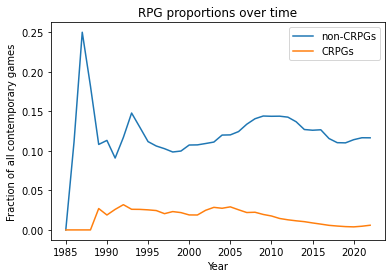

In [1060]:
#Plot change in proportion of RPGs over time
plt.figure()

dates = range(min(ncrpgs_df['releaseDate']).year,dt.now().year)

plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [ncrpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='non-CRPGs')
plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [crpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='CRPGs')
# plt.plot(dates, crpgCount)

plt.title('RPG proportions over time')
plt.xlabel('Year')
plt.ylabel('Fraction of all contemporary games')

plt.legend()

# Review Data and Game Recommender (Explicit Feedback)

In [8]:
#Get reviews data
reviews = pd.read_json('SteamReviewsData.json')

Per the discussion at https://github.com/lyst/lightfm/issues/204, when you have positive and negative interactions and are trying to fit a LightFM model, it is useful to encode the data differently depending on the loss function. For 'logistic' loss, positive and negative interactions should be encoded as 1 and -1 respectively; for other loss functions, the encoding should be 1 and 0. Since my data has positive and negative reviews, I will generate two different data matrices for these two cases before fitting any models.

In [38]:
reviews['reviews'].iloc[0]

[{'recommendationid': '98147510',
  'author': {'steamid': '76561198974872127',
   'num_games_owned': 39,
   'num_reviews': 19,
   'playtime_forever': 237,
   'playtime_last_two_weeks': 0,
   'playtime_at_review': 237,
   'last_played': 1629809168},
  'language': 'english',
  'review': "The game is good, but I did not like it because of the strange networking. The controls are terrible, the graphics are good. The optimization is terrible. The engine is disgusting. \nSo it's not worth spending your money on something like this…",
  'timestamp_created': 1629809492,
  'timestamp_updated': 1629809492,
  'voted_up': False,
  'votes_up': 12,
  'votes_funny': 1,
  'weighted_vote_score': '0.623708605766296387',
  'comment_count': 0,
  'steam_purchase': True,
  'received_for_free': False,
  'written_during_early_access': False},
 {'recommendationid': '101029172',
  'author': {'steamid': '76561198022964310',
   'num_games_owned': 1783,
   'num_reviews': 67,
   'playtime_forever': 161,
   'playtim

In [9]:
#Create dataframes (one for logistic loss, one for all other loss functions) containing all review info, with columns for
#author IDs, app IDs, and ratings (Boolean variable, 1 = positive rating, 0 = negative rating).
authorIDs = [];
gameIDs = [];
ratings = [];
ratingsLogistic = [];

#Create dataframe for later construction of author features matrix
authorFeatures = [];
authorCount = 0;

for index, game in reviews.iterrows():
    for recommendation in game['reviews']:
        authorIDs.append(recommendation['author']['steamid'])
        gameIDs.append(game['appId'])
        
        gameRating = recommendation['voted_up']
        #numReviews = len(game['reviews'])
        
        #Create ratings data for fitting models with loss functions other than logistic
        #Append gameRating = 1 if voted_up == True, and = 0 if voted_up == False
        ratings.append(int(gameRating))
        
        #Create ratings data for fitting model with logistic loss function
        #Append gameRating = 1 if voted_up == True, and = -1 if voted_up == False
        ratingsLogistic.append(gameRating + (1 - gameRating)*-1)
        
        #Also weight this value by number of reviews this game received
        #ratings.append((gameRating + (1 - gameRating)*-1)/numReviews)
        
        #Add info about author to dataframe
        authorFeatures.append({'authorID': recommendation['author']['steamid'],
                               'num_games_owned': recommendation['author']['num_games_owned'],
                               'num_reviews': recommendation['author']['num_reviews']})
        
reviewsDict = {'authorID': authorIDs, 'appID': gameIDs, 'rating': ratings};
reviewsDictLogistic = {'authorID': authorIDs, 'appID': gameIDs, 'rating': ratingsLogistic};

reviewsData = pd.DataFrame(data=reviewsDict).sort_values(by=['authorID']).drop_duplicates(['authorID','appID'])
reviewsDataLogistic = pd.DataFrame(data=reviewsDictLogistic).sort_values(by=['authorID']).drop_duplicates(['authorID','appID'])

#Create dataframe of authorFeatures; sort and drop duplicate authors
authorFeaturesData = pd.DataFrame.from_dict(authorFeatures).sort_values(by=['authorID']).drop_duplicates(['authorID'])

In [11]:
#Create game features dataframe
gameFeatures = [];

for game in rawGames.iterrows():
    gameFeatures.append({'appID': game[1]['appId'], 'tag': game[1]['tagsList'], 'numReviews': game[1]['numReviews'], 'dlcBool': 1*(game[1]['dlcBool'] == 'True')})
        
gameFeaturesData = pd.DataFrame.from_dict(gameFeatures).sort_values(by=['appID'])

In [56]:
len(reviewsData.authorID.unique())

247703

In [12]:
nLargest = 50

gameFeaturesTagList = []

for game in gameFeaturesData.iterrows():
    gameFeaturesTagList += game[1]['tag']
    
gameTagsCountList = pd.Series(gameFeaturesTagList)

In [13]:
#Get list of top N tags
nLargest = 50

topTags = pd.Series(gameTagsCountList).value_counts().nlargest(n=nLargest).index.to_list()

gameFeaturesTagsUpdate = []

#Remove tags from tagsList features that are not in the topTags list
for game in gameFeaturesData.iterrows():
    gameFeaturesTagsUpdate.append(np.array(game[1]['tag'])[np.in1d(game[1]['tag'],topTags)].tolist())

#Update game features with trimmed tags
gameFeaturesData.update(pd.DataFrame({'tag': gameFeaturesTagsUpdate}))

In [ ]:
print(topTags)
gameFeaturesData

In [15]:
#Create empty list for collecting the counts of reviews for each author
authorReviewsCount = {}

#Create dictionary of review counts for each author, initialized to zero
for uniqueAuthor in reviewsData['authorID'].unique():
    
    #Append to dictionary
    authorReviewsCount[uniqueAuthor] = 0
    
#Iterate through review data
for review in reviewsData.iterrows():
    
    #Add to review count
    authorReviewsCount[review[1]['authorID']] = authorReviewsCount[review[1]['authorID']] + 1

Text(0.5, 0, 'Number of reviews')

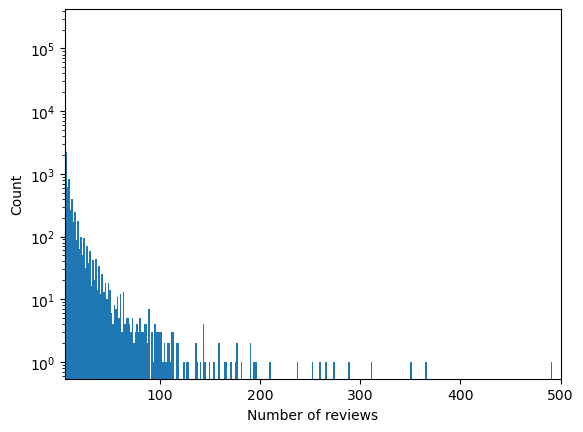

In [55]:

#Make a histogram of review numbers
plt.hist(authorReviewsCount.values(), bins = 500)

plt.xlim(5,500)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Number of reviews')

In [ ]:
#Histogram of reviews per game
plt.hist(gameFeaturesData['numReviews'].values, bins = 500)

plt.xlim(1,500000)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Number of reviews')

There are >100,000 reviewers (accounting for about about 40% of all reviews) who have left only 1 review, and about half of users left fewer than 2 reviews. We can try training on this data and try another model only including reviewers with 2 or more reviews.

In [16]:
#Restrict dataset to reviewers with more than some number of reviews

reviewNumberCutoff = 5

reviewsDataCutoff = {}
reviewsDataCutoffLogistic = {}

for review in reviewsData.iterrows():
    
    if authorReviewsCount[review[1]['authorID']] >= reviewNumberCutoff:
        reviewsDataCutoff[review[0]] = True
        
    else:
        reviewsDataCutoff[review[0]] = False

for review in reviewsDataLogistic.iterrows():
    
    if authorReviewsCount[review[1]['authorID']] >= reviewNumberCutoff:
        reviewsDataCutoffLogistic[review[0]] = True
        
    else:
        reviewsDataCutoffLogistic[review[0]] = False        

#Create Boolean indexing array
reviewsCutoffBool = pd.Series(reviewsDataCutoff)
reviewsCutoffBoolLogistic = pd.Series(reviewsDataCutoffLogistic)

#Remove reviewers with review counts below the cutoff
reviewsDataCutoff = reviewsData[reviewsCutoffBool]
reviewsDataCutoffLogistic = reviewsData[reviewsCutoffBoolLogistic]

reviewsDataCutoff.reset_index(inplace=True)
reviewsDataCutoffLogistic.reset_index(inplace=True)

In [17]:
uniqueTagList = uniqueTagNames.tolist()

# for feature in ['numReviews','dlcBool']:
#     uniqueTagList.append(feature)

In [18]:
#Add tag, numReviews, and dlcBool to feature mapping
from lightfm.data import Dataset
dataset = Dataset()

dataset.fit_partial(users=[authorFeature[1]['authorID'] for authorFeature in authorFeaturesData.iterrows()],
                    user_features=None,
                    items=[gameFeature[1]['appID'] for gameFeature in gameFeaturesData.iterrows()],
                    item_features=topTags)

# dataset.fit_partial(items=(gameFeature[1]['appID'] for gameFeature in gameFeaturesData.iterrows()),
#                     item_features=(gameFeature[1]['numReviews'] for gameFeature in gameFeaturesData.iterrows()))
                    
# dataset.fit_partial(items=(gameFeature[1]['appID'] for gameFeature in gameFeaturesData.iterrows()),
#                     item_features=(gameFeature[1]['dlcBool'] for gameFeature in gameFeaturesData.iterrows()))

C:\Users\phyis\miniconda3\envs\phd_env\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [19]:
tagFeatures = dataset.build_item_features([(gameFeature[1]['appID'],
                                            gameFeature[1]['tag'])
                                            for gameFeature in gameFeaturesData.iterrows()],normalize=True)

# userFeatures = dataset.build_user_features([(authorFeature[1]['authorID'],
#                                             {'num_games_owned': authorFeature[1]['num_games_owned']})
#                                             for authorFeature in authorFeaturesData.iterrows()],normalize=True)

# #Now build the interaction COO matrix
# (reviewSparseMatrix, weights) = dataset.build_interactions(((reviewsDataCutoff['authorID'].iloc[index],
#                                                              reviewsDataCutoff['appID'].iloc[index])
#                                                              for index in reviewsDataCutoff.index))

print(repr(tagFeatures))

<113010x113060 sparse matrix of type '<class 'numpy.float32'>'
	with 800287 stored elements in Compressed Sparse Row format>


In [44]:
gameFeaturesData.appID.unique()

array([     10,      20,      30, ..., 2001710, 2028023, 2028850],
      dtype=int64)

In [58]:
reviewsData

,authorID,appID,rating
106503,76561197960265841,1825540,1
299147,76561197960265942,310110,0
258749,76561197960268079,446110,1
30044,76561197960268765,1542040,1
71200,76561197960268765,1081870,1
...,...,...,...
107385,76561199367992022,1868050,1
360963,76561199368056737,356570,1
104381,76561199368683393,1806610,1
387657,76561199368686333,960990,0


In [13]:
len(reviewsData['authorID'].unique())

247703

In [20]:
#Now build the interaction COO matrix
(reviewSparseMatrix, weights) = dataset.build_interactions(((reviewsDataCutoff['authorID'].iloc[index],
                                                             reviewsDataCutoff['appID'].iloc[index])
                                                             for index in reviewsDataCutoff.index))

In [21]:
#Now build the interaction COO matrix for logistic loss function
(reviewSparseMatrixLogistic, weights) = dataset.build_interactions(((reviewsDataCutoffLogistic['authorID'].iloc[index],
                                                             reviewsDataCutoffLogistic['appID'].iloc[index])
                                                             for index in reviewsDataCutoffLogistic.index))

In [1157]:
#Create ID mappings between authors and games
from lightfm.data import Dataset

dataset.fit(reviewsDataCutoff['authorID'].to_list(),
            reviewsDataCutoff['appID'].to_list())

In [1181]:
range(reviewsDataCutoff.shape[0])[-1]

392702

In [1184]:
print(repr(reviewSparseMatrix))

<247703x61313 sparse matrix of type '<class 'numpy.int32'>'
	with 392703 stored elements in COOrdinate format>


In [28]:
#Convert the reviews dataframe to a sparse interactions matrix
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

authorUnique = CategoricalDtype(sorted(reviewsDataCutoff.authorID.unique()), ordered=True)
appUnique = CategoricalDtype(sorted(reviewsDataCutoff.appID.unique()), ordered=True)

reviewRow = reviewsDataCutoff.authorID.astype(authorUnique).cat.codes
reviewCol = reviewsDataCutoff.appID.astype(appUnique).cat.codes

# reviewCol = reviewsDataCutoff.authorID.astype(authorUnique).cat.codes
# reviewRow = reviewsDataCutoff.appID.astype(appUnique).cat.codes

reviewSparseMatrix = csr_matrix((reviewsDataCutoff['rating'], (reviewRow, reviewCol)), \
                                shape=(authorUnique.categories.size, appUnique.categories.size))

reviewSparseMatrixLogistic = csr_matrix((reviewsDataCutoffLogistic['rating'], (reviewRow, reviewCol)), \
                                shape=(authorUnique.categories.size, appUnique.categories.size))

# reviewSparseMatrix = csr_matrix((reviewsDataCutoff['rating'], (reviewRow, reviewCol)), \
#                                 shape=(appUnique.categories.size, authorUnique.categories.size))


In [1146]:
reviewSparseMatrix.shape

(247703, 61313)

In [1492]:
userDict = {};
counter = 0

for authorID in reviewsDataCutoff['authorID'].unique():
    userDict[authorID] = counter
    counter += 1

In [848]:
itemDict ={}

reviewGameNames = [rawGames[rawGames['appId'] == appID]['name'].to_string(index=False) \
                  for appID in reviewsData['appID'].to_list()]

itemDictDF = pd.DataFrame({'appID': reviewsData['appID'].to_list(), 'appName': reviewGameNames}).sort_values('appID').reset_index()

for i in range(itemDictDF.shape[0]):
    itemDict[(itemDictDF.loc[i,'appID'])] = itemDictDF.loc[i,'appName']


In [22]:
#Split data into training and test sets
from lightfm.cross_validation import random_train_test_split

#Remove some of the data to speed up training during hyperparameter tuning
# reviewSparseMatrix_shrink, reviewSparseMatrix_nonshrink = random_train_test_split(reviewSparseMatrix, test_percentage=0.7, random_state=43)
# reviewSparseMatrixLogistic_shrink, reviewSparseMatrixLogistic_nonshrink = random_train_test_split(reviewSparseMatrixLogistic, test_percentage=0.7, random_state=43)

reviewSparseMatrix_train, reviewSparseMatrix_nontrain = random_train_test_split(reviewSparseMatrix, random_state=43)
reviewSparseMatrixLogistic_train, reviewSparseMatrixLogistic_nontrain = random_train_test_split(reviewSparseMatrixLogistic, random_state=43)

reviewSparseMatrix_validation, reviewSparseMatrix_test = random_train_test_split(reviewSparseMatrix_nontrain, random_state=43,test_percentage=0.5)
reviewSparseMatrixLogistic_validation, reviewSparseMatrixLogistic_test = random_train_test_split(reviewSparseMatrixLogistic_nontrain, random_state=43,test_percentage=0.5)

In [51]:
#Find best possible value of precision at k for a given k
k = 10

precisionAtKMax = 0
highestReviewCount = max(list(authorReviewsCount.values()))
numReviewers = len(list(authorReviewsCount.values()))

for ki in np.arange(1,highestReviewCount+1):
    
    if ki<=k:
        precisionAtKMax += (1 - (ki==1))*ki*len(np.array(list(authorReviewsCount.values()))[np.array(list(authorReviewsCount.values())) == ki])/k/numReviewers
        
    else:
        precisionAtKMax += len(np.array(list(authorReviewsCount.values()))[np.array(list(authorReviewsCount.values())) > ki])/numReviewers
   

print(precisionAtKMax)

0.2114504063333929


In [45]:
from lightfm import LightFM

hyperparameters = {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8}
model = LightFM(**hyperparameters)
model = model.fit(reviewSparseMatrix_train,
                  user_features=None,
                  item_features=tagFeatures,
                  epochs=31,
                  num_threads=4, verbose=True)

print("Train set AUC score:",auc_score(model, reviewSparseMatrix_train, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
print("Test set AUC score:",auc_score(model, reviewSparseMatrix_test, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Train set AUC score: 0.8759492
Test set AUC score: 0.55725884


In [ ]:
from lightfm import LightFM

# hyperparameters = {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8}

hyperparameters = {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 27, 'learning_rate': 0.27356018665070686, 'item_alpha': 9.259837751692955e-05, 'user_alpha': 7.950089746289809e-05, 'max_sampled': 9}

model = LightFM(**hyperparameters)

for epoch in np.arange(20):
    model.fit_partial(reviewSparseMatrix_train,
                  user_features=None,
                  item_features=tagFeatures,
                  epochs=1,
                  num_threads=4, verbose=True)
    print("Train set precision at k (epoch {}):".format(epoch),precision_at_k(model, reviewSparseMatrix_train, k=5 train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
    print("Test set precision at k (epoch {}):".format(epoch),precision_at_k(model, reviewSparseMatrix_test, k=5 train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())


In [24]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

# hyperparameters = {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8}
hyperparameters = {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 27, 'learning_rate': 0.27356018665070686, 'item_alpha': 9.259837751692955e-05, 'user_alpha': 7.950089746289809e-05, 'max_sampled': 9}
model = LightFM(**hyperparameters)

for epoch in np.arange(25,30):
    
    if epoch == 25:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=25,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epoch {}):".format(epoch),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epoch {}):".format(epoch),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        
    else:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=(epoch-25 + 1)*25,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epoch {}):".format(epoch),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epoch {}):".format(epoch),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Train set precision at k (epoch 25): 0.0018159206
Test set precision at k (epoch 25): 4.1710115e-05
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Train set precision at k (epoch 26): 0.07654229
Test set precision at k (epoch 26): 0.002502607
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 

In [25]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

# hyperparameters = {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8}
hyperparameters = {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 27, 'learning_rate': 0.27356018665070686, 'item_alpha': 9.259837751692955e-05, 'user_alpha': 7.950089746289809e-05, 'max_sampled': 9}
model = LightFM(**hyperparameters)

for epoch in np.arange(125,135):
    
    if epoch == 125:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=125,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epoch {}):".format((epoch-125 + 1)*25+100),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epoch {}):".format((epoch-125 + 1)*25+100),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        
    else:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=(epoch-125 + 1)*25+100,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epoch {}):".format((epoch-125 + 1)*25+100),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epoch {}):".format((epoch-125 + 1)*25+100),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


KeyboardInterrupt: 

In [26]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

# hyperparameters = {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8}
hyperparameters = {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 27, 'learning_rate': 0.27356018665070686*2, 'item_alpha': 9.259837751692955e-05*100, 'user_alpha': 7.950089746289809e-05*100, 'max_sampled': 9}
model = LightFM(**hyperparameters)

epochCount = 1

for epoch in np.arange(125,135):
    
    if epoch == 125:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=125,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        
        epochCount+=125
        
    else:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=(epoch-125 + 1)*125,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())

        epochCount+=125

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


KeyboardInterrupt: 

In [34]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

# hyperparameters = {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8}
hyperparameters = {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 27, 'learning_rate': 0.27356018665070686, 'item_alpha': 9.259837751692955e-05*4, 'user_alpha': 7.950089746289809e-05*4, 'max_sampled': 9}
model = LightFM(**hyperparameters)

epochCount = 100

for epoch in np.arange(100,110):
    
    if epoch == 100:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=100,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        
        epochCount+=100
        
    else:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=(epoch-100 + 1)*100,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())

        epochCount+=100

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Train set precision at k (epochs 100): 0.0048756218
Test set precision at k (epochs 100): 0.0005005214
Epoch 0

Epoch 233
Epoch 234
Epoch 235
Epoch 236
Epoch 237
Epoch 238
Epoch 239
Epoch 240
Epoch 241
Epoch 242
Epoch 243
Epoch 244
Epoch 245
Epoch 246
Epoch 247
Epoch 248
Epoch 249
Epoch 250
Epoch 251
Epoch 252
Epoch 253
Epoch 254
Epoch 255
Epoch 256
Epoch 257
Epoch 258
Epoch 259
Epoch 260
Epoch 261
Epoch 262
Epoch 263
Epoch 264
Epoch 265
Epoch 266
Epoch 267
Epoch 268
Epoch 269
Epoch 270
Epoch 271
Epoch 272
Epoch 273
Epoch 274
Epoch 275
Epoch 276
Epoch 277
Epoch 278
Epoch 279
Epoch 280
Epoch 281
Epoch 282
Epoch 283
Epoch 284
Epoch 285
Epoch 286
Epoch 287
Epoch 288
Epoch 289
Epoch 290
Epoch 291
Epoch 292
Epoch 293
Epoch 294
Epoch 295
Epoch 296
Epoch 297
Epoch 298
Epoch 299
Epoch 300
Epoch 301
Epoch 302
Epoch 303
Epoch 304
Epoch 305
Epoch 306
Epoch 307
Epoch 308
Epoch 309
Epoch 310
Epoch 311
Epoch 312
Epoch 313
Epoch 314
Epoch 315
Epoch 316
Epoch 317
Epoch 318
Epoch 319
Epoch 320
Epoch 321
Epoch 322
Epoch 323
Epoch 324
Epoch 325
Epoch 326
Epoch 327
Epoch 328
Epoch 329
Epoch 330
Epoch 331
Epoch 332


Epoch 154
Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
Epoch 180
Epoch 181
Epoch 182
Epoch 183
Epoch 184
Epoch 185
Epoch 186
Epoch 187
Epoch 188
Epoch 189
Epoch 190
Epoch 191
Epoch 192
Epoch 193
Epoch 194
Epoch 195
Epoch 196
Epoch 197
Epoch 198
Epoch 199
Epoch 200
Epoch 201
Epoch 202
Epoch 203
Epoch 204
Epoch 205
Epoch 206
Epoch 207
Epoch 208
Epoch 209
Epoch 210
Epoch 211
Epoch 212
Epoch 213
Epoch 214
Epoch 215
Epoch 216
Epoch 217
Epoch 218
Epoch 219
Epoch 220
Epoch 221
Epoch 222
Epoch 223
Epoch 224
Epoch 225
Epoch 226
Epoch 227
Epoch 228
Epoch 229
Epoch 230
Epoch 231
Epoch 232
Epoch 233
Epoch 234
Epoch 235
Epoch 236
Epoch 237
Epoch 238
Epoch 239
Epoch 240
Epoch 241
Epoch 242
Epoch 243
Epoch 244
Epoch 245
Epoch 246
Epoch 247
Epoch 248
Epoch 249
Epoch 250
Epoch 251
Epoch 252
Epoch 253


Epoch 374
Epoch 375
Epoch 376
Epoch 377
Epoch 378
Epoch 379
Epoch 380
Epoch 381
Epoch 382
Epoch 383
Epoch 384
Epoch 385
Epoch 386
Epoch 387
Epoch 388
Epoch 389
Epoch 390
Epoch 391
Epoch 392
Epoch 393
Epoch 394
Epoch 395
Epoch 396
Epoch 397
Epoch 398
Epoch 399
Epoch 400
Epoch 401
Epoch 402
Epoch 403
Epoch 404
Epoch 405
Epoch 406
Epoch 407
Epoch 408
Epoch 409
Epoch 410
Epoch 411
Epoch 412
Epoch 413
Epoch 414
Epoch 415
Epoch 416
Epoch 417
Epoch 418
Epoch 419
Epoch 420
Epoch 421
Epoch 422
Epoch 423
Epoch 424
Epoch 425
Epoch 426
Epoch 427
Epoch 428
Epoch 429
Epoch 430
Epoch 431
Epoch 432
Epoch 433
Epoch 434
Epoch 435
Epoch 436
Epoch 437
Epoch 438
Epoch 439
Epoch 440
Epoch 441
Epoch 442
Epoch 443
Epoch 444
Epoch 445
Epoch 446
Epoch 447
Epoch 448
Epoch 449
Epoch 450
Epoch 451
Epoch 452
Epoch 453
Epoch 454
Epoch 455
Epoch 456
Epoch 457
Epoch 458
Epoch 459
Epoch 460
Epoch 461
Epoch 462
Epoch 463
Epoch 464
Epoch 465
Epoch 466
Epoch 467
Epoch 468
Epoch 469
Epoch 470
Epoch 471
Epoch 472
Epoch 473


Epoch 494
Epoch 495
Epoch 496
Epoch 497
Epoch 498
Epoch 499
Epoch 500
Epoch 501
Epoch 502
Epoch 503
Epoch 504
Epoch 505
Epoch 506
Epoch 507
Epoch 508
Epoch 509
Epoch 510
Epoch 511
Epoch 512
Epoch 513
Epoch 514
Epoch 515
Epoch 516
Epoch 517
Epoch 518
Epoch 519
Epoch 520
Epoch 521
Epoch 522
Epoch 523
Epoch 524
Epoch 525
Epoch 526
Epoch 527
Epoch 528
Epoch 529
Epoch 530
Epoch 531
Epoch 532
Epoch 533
Epoch 534
Epoch 535
Epoch 536
Epoch 537
Epoch 538
Epoch 539
Epoch 540
Epoch 541
Epoch 542
Epoch 543
Epoch 544
Epoch 545
Epoch 546
Epoch 547
Epoch 548
Epoch 549
Epoch 550
Epoch 551
Epoch 552
Epoch 553
Epoch 554
Epoch 555
Epoch 556
Epoch 557
Epoch 558
Epoch 559
Epoch 560
Epoch 561
Epoch 562
Epoch 563
Epoch 564
Epoch 565
Epoch 566
Epoch 567
Epoch 568
Epoch 569
Epoch 570
Epoch 571
Epoch 572
Epoch 573
Epoch 574
Epoch 575
Epoch 576
Epoch 577
Epoch 578
Epoch 579
Epoch 580
Epoch 581
Epoch 582
Epoch 583
Epoch 584
Epoch 585
Epoch 586
Epoch 587
Epoch 588
Epoch 589
Epoch 590
Epoch 591
Epoch 592
Epoch 593


Epoch 514
Epoch 515
Epoch 516
Epoch 517
Epoch 518
Epoch 519
Epoch 520
Epoch 521
Epoch 522
Epoch 523
Epoch 524
Epoch 525
Epoch 526
Epoch 527
Epoch 528
Epoch 529
Epoch 530
Epoch 531
Epoch 532
Epoch 533
Epoch 534
Epoch 535
Epoch 536
Epoch 537
Epoch 538
Epoch 539
Epoch 540
Epoch 541
Epoch 542
Epoch 543
Epoch 544
Epoch 545
Epoch 546
Epoch 547
Epoch 548
Epoch 549
Epoch 550
Epoch 551
Epoch 552
Epoch 553
Epoch 554
Epoch 555
Epoch 556
Epoch 557
Epoch 558
Epoch 559
Epoch 560
Epoch 561
Epoch 562
Epoch 563
Epoch 564
Epoch 565
Epoch 566
Epoch 567
Epoch 568
Epoch 569
Epoch 570
Epoch 571
Epoch 572
Epoch 573
Epoch 574
Epoch 575
Epoch 576
Epoch 577
Epoch 578
Epoch 579
Epoch 580
Epoch 581
Epoch 582
Epoch 583
Epoch 584
Epoch 585
Epoch 586
Epoch 587
Epoch 588
Epoch 589
Epoch 590
Epoch 591
Epoch 592
Epoch 593
Epoch 594
Epoch 595
Epoch 596
Epoch 597
Epoch 598
Epoch 599
Epoch 600
Epoch 601
Epoch 602
Epoch 603
Epoch 604
Epoch 605
Epoch 606
Epoch 607
Epoch 608
Epoch 609
Epoch 610
Epoch 611
Epoch 612
Epoch 613


Epoch 434
Epoch 435
Epoch 436
Epoch 437
Epoch 438
Epoch 439
Epoch 440
Epoch 441
Epoch 442
Epoch 443
Epoch 444
Epoch 445
Epoch 446
Epoch 447
Epoch 448
Epoch 449
Epoch 450
Epoch 451
Epoch 452
Epoch 453
Epoch 454
Epoch 455
Epoch 456
Epoch 457
Epoch 458
Epoch 459
Epoch 460
Epoch 461
Epoch 462
Epoch 463
Epoch 464
Epoch 465
Epoch 466
Epoch 467
Epoch 468
Epoch 469
Epoch 470
Epoch 471
Epoch 472
Epoch 473
Epoch 474
Epoch 475
Epoch 476
Epoch 477
Epoch 478
Epoch 479
Epoch 480
Epoch 481
Epoch 482
Epoch 483
Epoch 484
Epoch 485
Epoch 486
Epoch 487
Epoch 488
Epoch 489
Epoch 490
Epoch 491
Epoch 492
Epoch 493
Epoch 494
Epoch 495
Epoch 496
Epoch 497
Epoch 498
Epoch 499
Epoch 500
Epoch 501
Epoch 502
Epoch 503
Epoch 504
Epoch 505
Epoch 506
Epoch 507
Epoch 508
Epoch 509
Epoch 510
Epoch 511
Epoch 512
Epoch 513
Epoch 514
Epoch 515
Epoch 516
Epoch 517
Epoch 518
Epoch 519
Epoch 520
Epoch 521
Epoch 522
Epoch 523
Epoch 524
Epoch 525
Epoch 526
Epoch 527
Epoch 528
Epoch 529
Epoch 530
Epoch 531
Epoch 532
Epoch 533


In [35]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

# hyperparameters = {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8}
hyperparameters = {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 27, 'learning_rate': 0.27356018665070686, 'item_alpha': 9.259837751692955e-05, 'user_alpha': 7.950089746289809e-05, 'max_sampled': 9}
model = LightFM(**hyperparameters)

epochCount = 50

for epoch in np.arange(50,70):
    
    if epoch == 50:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=50,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        
        print("Train set AUC score (epochs {}):".format(epochCount),auc_score(model, reviewSparseMatrix_train, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set AUC score (epochs {}):".format(epochCount),auc_score(model, reviewSparseMatrix_test, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())

        
        epochCount+=50
        
    else:
        model.fit_partial(reviewSparseMatrix_train,
                      user_features=None,
                      item_features=tagFeatures,
                      epochs=50,
                      num_threads=4, verbose=True)
        print("Train set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_train, k=5, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set precision at k (epochs {}):".format(epochCount),precision_at_k(model, reviewSparseMatrix_test, k=5, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        
        print("Train set AUC score (epochs {}):".format(epochCount),auc_score(model, reviewSparseMatrix_train, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
        print("Test set AUC score (epochs {}):".format(epochCount),auc_score(model, reviewSparseMatrix_test, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())

        
        epochCount+=50

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Train set precision at k (epochs 50): 0.046915423
Test set precision at k (epochs 50): 0.0012513035
Train set AUC score (epochs 50): 0.99969804
Test set AUC score (epochs 50): 0.7099136
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 

Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Train set precision at k (epochs 700): 0.7419154
Test set precision at k (epochs 700): 0.012012512
Train set AUC score (epochs 700): 0.99998486
Test set AUC score (epochs 700): 0.71287024
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 4

In [104]:
#Predict top game for userX
import random

user = 0
numUsers = 10
iteration = 0

while user < numUsers:
    userIDMap = dataset.mapping()[0]
    itemIDMap = dataset.mapping()[2]

    userX = random.choice(list(dataset.mapping()[0].values()))
    
    authorID = list(userIDMap.keys())[userX]
    
    if authorReviewsCount[authorID] >= 5:
        print(userX)

        scores = np.array(model.predict(np.repeat(userX,len(itemIDMap)),list(itemIDMap.values()), item_features=tagFeatures, user_features=None))

        print(scores.max())

        top5GamesBool = pd.Series(scores).nlargest(n=5).index

        top5List = []
        for top5Game in top5GamesBool:

            game = rawGames[rawGames['appId'] == list(itemIDMap.keys())[list(itemIDMap.values()).index(top5Game)]]['name'].values[0]
            top5List.append(game)

        print(top5List)

        user += 1

133906
4.926427
['Shadow Warrior 2: The Way of the Wang DLC', 'Resident Evil 6: Survivors Mode', 'Shadow of the Tomb Raider - Deluxe Extras', 'Homefront®: The Revolution - Aftermath', 'Homefront®: The Revolution - The Voice of Freedom']
28391
0.56334585
['FreakOut: Extreme Freeride', 'Insurgency: Sandstorm - Hunter Weapon Skin Set', 'Motorcycle Club', 'Pinball FX3 - Jurassic World\x99 Pinball', 'Jelly in the sky']
132967
3.1568534
['Alien Worms Invasion', 'CAPSULE', 'The Cassir Simulator', 'Defense of Roman Britain', 'Deep Cave']
26108
4.1418567
['Colour Bind', 'Jacob Jones and the Bigfoot Mystery : Episode 2', 'RoboBlitz', 'Jacob Jones and the Bigfoot Mystery : Episode 1', 'Paradox Wrench']
9256
3.213053
['Dark Train', 'DARK SOULS\x99 II Crown of the Old Iron King', 'Fallout 3 - Point Lookout', 'The Watchers', 'DARK SOULS\x99 II Crown of the Sunken King']
37699
3.5606294
['Konung 3: Ties of the Dynasty', 'Indeep | The casual dungeon crawler', 'Ruzar - The Life Stone - Challenge Map', 

In [105]:
def listReviews(LightFM_ID):
    authorID = list(dataset.mapping()[0].keys())[LightFM_ID]
    app_ID = reviewsData[reviewsData['authorID'] == authorID]['appID']

    for game in app_ID.values:
        print(rawGames[rawGames['appId'] == game].name.values)
        
listReviews(9256)

['Krater']
['FIVE: Champions of Canaan']
['Unforgiving - A Northern Hymn']
['Toren']
['Titan Attacks!']


In [49]:
#Evaluate model performance
from lightfm.evaluation import auc_score

performanceScore = auc_score(model, reviewSparseMatrix_test, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures)

In [50]:
np.average(performanceScore)

0.6633947

In [ ]:
import itertools

import numpy as np

import time

from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        n = np.random.randint(5,30)
        k = np.random.randint(1,n)
        yield {
            "no_components": np.random.randint(16, 84),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["logistic","warp", "warp-kos","bpr"]),
            "k": k,
            "n": n,
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(2, 15),
            "num_epochs": np.random.randint(5, 70),
        }


def random_search(train, trainLogistic, test, testLogistic, num_samples=20, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    start = time.time()
    
    models = 1
    
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        
        if hyperparams['loss'] == 'logistic':
            model.fit(trainLogistic, epochs=num_epochs, num_threads=num_threads, user_features=None, item_features=tagFeatures)

            score = precision_at_k(model, testLogistic, k=15, train_interactions=trainLogistic, user_features=None, item_features=tagFeatures,num_threads=num_threads).mean()
            
            print('Model {} completed {} seconds after start. Precision at k for this model: {}'.format(models, time.time() - start,np.average(score)))
            
        else:
            model.fit(train, epochs=num_epochs, num_threads=num_threads, user_features=None, item_features=tagFeatures)

            score = precision_at_k(model, test, k=15, train_interactions=train, user_features=None, item_features=tagFeatures,num_threads=num_threads).mean()
            
            print('Model {} completed {} seconds after start. Precision at k for this model: {}'.format(models, time.time() - start,np.average(score)))
     
        hyperparams["num_epochs"] = num_epochs

        print('Hyperparameters for this model:',hyperparams)
        
        yield (score, hyperparams, model)
        
        models += 1


if __name__ == "__main__":
    train = reviewSparseMatrix_train
    test = reviewSparseMatrix_validation
    
    trainLogistic = reviewSparseMatrixLogistic_train
    testLogistic = reviewSparseMatrixLogistic_validation

    (score, hyperparams, model) = max(random_search(train, trainLogistic, test, testLogistic, num_threads=4), key=lambda x: x[0])

    print("Best score {} at {}".format(score, hyperparams))

Model 1 completed 563.5711710453033 seconds after start. Precision at k for this model: 7.007217936916277e-05
Hyperparameters for this model: {'no_components': 26, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'k': 7, 'n': 19, 'learning_rate': 0.2726513635735333, 'item_alpha': 1.4891160209682287e-06, 'user_alpha': 9.716922366584673e-05, 'max_sampled': 4, 'num_epochs': 40}
Model 2 completed 1002.8846809864044 seconds after start. Precision at k for this model: 0.0022703385911881924
Hyperparameters for this model: {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 27, 'learning_rate': 0.27356018665070686, 'item_alpha': 9.259837751692955e-05, 'user_alpha': 7.950089746289809e-05, 'max_sampled': 9, 'num_epochs': 56}
Model 3 completed 1916.6710376739502 seconds after start. Precision at k for this model: 2.8028871383867227e-05
Hyperparameters for this model: {'no_components': 47, 'learning_schedule': 'adadelta', 'loss': 'warp', 'k': 2, 'n': 5, 'learning

In [37]:
print("Train set AUC score:",auc_score(model, reviewSparseMatrix_train, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
print("Test set AUC score:",auc_score(model, reviewSparseMatrix_test, train_interactions=reviewSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())


Train set AUC score: 0.87648803
Test set AUC score: 0.561625


In [ ]:
#Optimization results:
#
#Performances on dataset with cutoff at 10 reviews:
#
#(Number of models = 10) Best score 0.651569664478302 at {'no_components': 52, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.1527113318869582, 'item_alpha': 1.0645979288543401e-08, 'user_alpha': 1.111435154654254e-08, 'max_sampled': 14, 'num_epochs': 20}
#
#(Number of models = 100) Best score 0.6798270344734192 at {'no_components': 55, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.14499587224888172, 'item_alpha': 2.449496687288527e-08, 'user_alpha': 3.5844794576049884e-08, 'max_sampled': 6, 'num_epochs': 37}
#
#Performances on dataset with no cutoff:
#
#(Number of models = 10) Best score 0.7345967292785645 at {'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.009298331793000566, 'item_alpha': 8.897488524832826e-09, 'user_alpha': 1.6628688874535134e-09, 'max_sampled': 13, 'num_epochs': 26}
#
#Performances with two datasets, one for logistic loss, one for all other loss functions; no data cutoff.
#
#(Number of models = 50) ---------------------------
#
#Aborted run; I realized 'logistic' loss is not even considered in the hyperparameter grid!!
#
#Retrying after including 'logistic':
#
#(Number of models = 10) Best score 0.7065965533256531 at {'no_components': 62, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.0573779126646902, 'item_alpha': 1.0038960427872043e-08, 'user_alpha': 1.0230331754491065e-09, 'max_sampled': 7, 'num_epochs': 15}
#
#Performances with cutoff at 2 reviews:
#
#(Number of models = 10) Best score 0.6448951959609985 at {'no_components': 42, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.06211345003561848, 'item_alpha': 1.7683031781962732e-09, 'user_alpha': 7.90888741439592e-09, 'max_sampled': 7, 'num_epochs': 42}
#
#Seems that removing the single-review data entries doesn't help.
#Performances with no cutoff:
#
#(Number of models = 50) Best score 0.6859049201011658 at {'no_components': 73, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.014584564881958832, 'item_alpha': 5.394639329463036e-10, 'user_alpha': 3.1028310995598514e-08, 'max_sampled': 7, 'num_epochs': 5}
#
#A decent result, but still not the best. I have two ideas for improving performance:
# 1) The 'warp-kos' loss function seems to be doing well, but the hyperparameter grid is not randomizing 'k' or 'n'. It might be worthwhile to include k and n in the grid.
# 2) We are so far only training the model with the interaction matrix, which means we are not fully exploiting the power of LightFM. To do better, I will construct user-feature and item-feature matrices to include in training.
#
#Performances with no cutoff, tags included in item_features, and numReviews included in user_features; also including n and k in hyperparameter grid.
#
#(Number of models = 10) Best score 0.8470107913017273 at {'no_components': 65, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 6, 'n': 12, 'learning_rate': 0.02928440331763431, 'item_alpha': 7.275228854163678e-09, 'user_alpha': 2.7338318258837908e-08, 'max_sampled': 10, 'num_epochs': 37}
#
#warp and warp-kOS outperform all other loss functions by a wide margin (0.3)! So I'll do another run with just those loss functions.
#
#(Number of models = 10) Best score 0.8526289463043213 at {'no_components': 72, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 3, 'n': 11, 'learning_rate': 0.1897451476865415, 'item_alpha': 3.0092438503624385e-09, 'user_alpha': 6.33702109340142e-08, 'max_sampled': 12, 'num_epochs': 28}
#
#Not bad, but not a big improvement. However, up to this point, I have not been optimizing on a validation set. I will implement this to make sure I am not getting any kind of train-test leakage.
#
#(Number of models = 10) Best score 0.8456214070320129 at {'no_components': 64, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 4, 'n': 16, 'learning_rate': 0.047083589797465575, 'item_alpha': 8.078502532221144e-09, 'user_alpha': 7.890520987668458e-10, 'max_sampled': 6, 'num_epochs': 26}
#
#The above is the best-performing model scored on the validation set.
#The final model of the 10 had the following parameters and performance on the validation set: 0.8360676765441895 with the parameters {'no_components': 65, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'k': 2, 'n': 17, 'learning_rate': 0.10304219169462017, 'item_alpha': 1.5928283813232654e-09, 'user_alpha': 1.6330383752596355e-09, 'max_sampled': 7}
#Its predicitions on the test set gave a score of 0.84640944. So the model generalizes well and seems to not be overfitting!
#
#Unfortunately, the model appears to be predicting mostly the same items for every user. I suspect this is because I am fitting
#with user features included; my user features are the number of reviews for each user, which may be inappropriate as the model
#is likely treating users with similar numbers of reviews as having similar taste.
#
#I tried training without user features and got different results for each user! The bad news, however, is my AUC score is now only ~0.66.
#That isn't the end of the world though. I can try to re-optimize the hyperparameters in the no-user-features condition and see how well I can do!
#
#(Number of models = 2) Best score 0.6793850064277649 at{'no_components': 80, 'learning_schedule': 'adadelta', 'loss': 'warp', 'k': 1, 'n': 17, 'learning_rate': 0.03447291023596468, 'item_alpha': 4.218587807853474e-09, 'user_alpha': 1.0118587621171197e-09, 'max_sampled': 5}
#
#Terminated early. warp loss seems promising again after fixing things; however, now that I have fixed some issues with the model, I wonder if restricting the dataset to users who have reviewed more than X games and games that have been reviewed more than Y times, I might be able to improve the model accuracy.
#
#Performances with reviews per user >= 5 and reviews per game >= 5:
#
#(Number of models = 2) Best score 0.8397705554962158 at {'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'k': 3, 'n': 13, 'learning_rate': 0.005281583069440484, 'item_alpha': 9.858565694780535e-09, 'user_alpha': 9.744293683760443e-09, 'max_sampled': 14}
#
#Back to high scores! I stopped early so I could check if it is giving unique recommendations to each user.
#The model recommended similar things for all users. Not sure what the problem is.
#
#(Number of models = 1) Best score 0.8866572380065918 at {'no_components': 80, 'learning_schedule': 'adadelta', 'loss': 'warp', 'k': 7, 'n': 15, 'learning_rate': 0.0033877415959418754, 'item_alpha': 1.904102913607403e-09, 'user_alpha': 7.227838565219844e-09, 'max_sampled': 6, 'num_epochs': 21}
#
#(Number of models = 10) Best score 0.7476821541786194 at {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 8, 'n': 19, 'learning_rate': 0.06907670508127313, 'item_alpha': 9.15443639916312e-09, 'user_alpha': 8.805455946727902e-09, 'max_sampled': 8, 'num_epochs': 41}
#
#It seems like I should be able to do better than AUC 0.75. Some recommenders are able to achieve >0.9 AUC score.
#Based on this intuition, I decided to check for overfitting in this model. I got the following results:
# Train set AUC score: 0.9993617
# Test set AUC score: 0.7465831
#I am obviously overfitting a great deal! Need to find a solution to this... perhaps k-fold cross validation?
#But this would not get our test AUC score much higher. The problem seems to happen at the level of model fitting, not hyperparameter selection.
#For that reason, I will first simply try restricting the number of epochs each model trains over.
#
#Now I've built a game features matrix that includes only the top 50 most popular tags. Let's see if this guards against overfitting.
#
#(Number of models = )

## Implicit Feedback
I tried many different avenues with the review data. Overall, the model performance is not stellar. Of the models that give sensible results (i.e., models that do not recommend the same thing to almost every user), peak performance is at an AUC score of 0.7 or precision at k of 0.1. While searching for ways to improve the model, I came across this talk https://maciejkula.github.io/2018/07/19/dont-use-explicit-feedback-recommenders/ which references this paper https://dl.acm.org/doi/pdf/10.1145/1835804.1835895; both argue that implicit feedback recommender systems generally outperform explicit feedback systems which, like the models I produced above, are based on user ratings. The reason is essentially that user ratings of games are not a random sample of user interactions with games, and so give a biased impression of how other users are likely to rate the same game. With that in mind, I have scraped Steam again, this time acquiring a list of games owned by each user ID from the above dataset. This will create a denser interactions matrix with a more representative sample of user interactions and, if the above arguments are correct, should produce a trained model with better performance.

Steam is very hesitant to allow heavy scraping of its user profile pages (possibly due to European privacy laws?). Anyway, it appears to allow one user ID's owned games list to be scraped every minute. It is slow-going, but I am able to obtain a large quantity of data this way. Each user I scrape has on average 1,000 user-item interactions, which is at least 100 times greater than what I had for the review data. So I am actually getting greater data quantity in addition to quality.

In [49]:
#Create list of user IDs to scrape over
# csvFile = open('SteamUsersIDs.csv', 'w+')
# writer = csv.writer(csvFile)
# writer.writerow(['userID'])

# for userID in reviewsData['authorID'].unique():
#     writer.writerow([userID])
    
# csvFile.close()

In [592]:
ownedGames = pd.read_csv('SteamUsersInfo_2-15-2023.csv', encoding = "ISO-8859-1")
ownedGames = ownedGames[ownedGames['ownedAppIDs'] != '[]'].reset_index(drop=True)

#Turn string of lists into list of strings
import ast

userIDStrings = [str(user) for user in ownedGames['userID']]
ownedGameLists = [ast.literal_eval(stringList) for stringList in ownedGames['ownedAppIDs'].values]

ownedGames['userID'] = userIDStrings
ownedGames['ownedAppIDs'] = ownedGameLists

In [593]:
ownedGames

,userID,ownedAppIDs
0,76561197960265841,"[594650, 578080, 892970, 1938090, 275850, 3593..."
1,76561197960265942,"[1147690, 570, 4920, 1468260, 1454400, 848480,..."
2,76561197960268765,"[730, 10, 310950, 1097840, 550, 1172470, 11340..."
3,76561197960269213,"[440, 230410, 363970, 238960, 251570, 564710, ..."
4,76561197960269409,"[570, 8930, 316010, 220200, 1286830, 203770, 6..."
...,...,...
2777,76561197970217405,"[552990, 56400, 24960, 312370, 10190, 440, 728..."
2778,76561197970218004,"[440, 218620, 1435790, 381210, 8930, 392110, 4..."
2779,76561197970218633,"[440, 570, 1046930, 620, 4550, 240, 583950, 20..."
2780,76561197970221907,"[1468260, 1546320, 550, 730, 486310, 363970, 6..."


Here I'll add my Steam library, and perhaps my friends' libraries to make recommendations for me and them. It is necessary to include my information before fitting the model if I want to predict games for myself with it.

In [594]:
#Add my games list to the model and recommend games for me
import ast

gamesDataLists = [ast.literal_eval(open('myGamesData.txt','r').read()),
                ast.literal_eval(open('JayGamesData.txt','r').read()),
                ast.literal_eval(open('MaryGamesData.txt','r').read()),
                ast.literal_eval(open('MicahGamesData.txt','r').read())]

ourIDsList = ['76561198030126834','76561198832487444','76561199152870578','76561198042764215']

for myGames, userID in zip(gamesDataLists,ourIDsList):

    myGamesData = pd.DataFrame({})

    myGamesData['userID'] = [userID]
    myGamesData['ownedAppIDs'] = [myGames]

    ownedGames = pd.concat([ownedGames,myGamesData],ignore_index=True)

ownedGames

,userID,ownedAppIDs
0,76561197960265841,"[594650, 578080, 892970, 1938090, 275850, 3593..."
1,76561197960265942,"[1147690, 570, 4920, 1468260, 1454400, 848480,..."
2,76561197960268765,"[730, 10, 310950, 1097840, 550, 1172470, 11340..."
3,76561197960269213,"[440, 230410, 363970, 238960, 251570, 564710, ..."
4,76561197960269409,"[570, 8930, 316010, 220200, 1286830, 203770, 6..."
...,...,...
2781,76561197970222247,"[47810, 39120, 578080, 1245620, 8980, 335300, ..."
2782,76561198030126834,"[761890, 346110, 407530, 1086940, 228280, 2573..."
2783,76561198832487444,"[1172470, 892970, 1063730, 1085660, 435150, 10..."
2784,76561199152870578,"[892970, 435150, 559650, 1330000, 1594940, 108..."


Now I'll build the dataset and features matrices with LightFM before training.

In [595]:
#Create dataframe of all user-item interactions
ownedGameInteractions = [];

for user in ownedGames.iterrows():
    for app in user[1]['ownedAppIDs']:
        ownedGameInteractions.append({'userID': user[1]['userID'], 'ownedAppIDs': app})
        
ownedGameInteractionsData = pd.DataFrame(ownedGameInteractions)

In [596]:
#List unique Steam apps in this dataset
uniqueAppIDs = pd.Series([j for i in range(len(ownedGames.ownedAppIDs)) for j in ownedGames.ownedAppIDs[i]]).unique().tolist()

In [597]:
len(uniqueAppIDs)

54739

In [598]:
#Create game features dataframe for generating the item features matrix
gameFeaturesImplicit = [];

for game in uniqueAppIDs:
    game = int(game)
    gameTags = rawGames[rawGames['appId'] == game]['tagsList'].values
    
    if len(gameTags) == 0:
        gameFeaturesImplicit.append({'appID': str(game), 'tag': gameTags})
        
    else:
        gameFeaturesImplicit.append({'appID': str(game), 'tag': gameTags[0]})
        
gameFeaturesDataImplicit = pd.DataFrame.from_dict(gameFeaturesImplicit)

In [599]:
gameFeaturesDataImplicit

,appID,tag
0,594650,"[Hunting, Dark, Tactical, FPS, Multiplayer, Ho..."
1,578080,"[Survival, Shooter, Multiplayer, Battle Royale..."
2,892970,"[Open World Survival Craft, Survival, Online C..."
3,1938090,[]
4,275850,"[Open World, Open World Survival Craft, Space,..."
...,...,...
54734,1940340,[]
54735,670060,"[Action, Indie, Adventure]"
54736,737390,"[Action, Massively Multiplayer, Indie, Early A..."
54737,906480,"[Indie, Action, Adventure]"


In [600]:
#Add tags to feature mapping
from lightfm.data import Dataset
dataset = Dataset()

dataset.fit_partial(users=ownedGames.userID.values.tolist(),
                    user_features=None,
                    items=uniqueAppIDs,
                    item_features=uniqueTagNames)

tagFeatures = dataset.build_item_features([(gameFeature[1]['appID'],
                                            gameFeature[1]['tag'])
                                            for gameFeature in gameFeaturesDataImplicit.iterrows()],normalize=True)

In [601]:
ownedGameInteractionsData

,userID,ownedAppIDs
0,76561197960265841,594650
1,76561197960265841,578080
2,76561197960265841,892970
3,76561197960265841,1938090
4,76561197960265841,275850
...,...,...
2926009,76561198042764215,488790
2926010,76561198042764215,329430
2926011,76561198042764215,22320
2926012,76561198042764215,292030


I've had some trouble with this model recommending games more for their popularity rather than tailoring its predicitons to the user's specific taste. For that reason, I'm going to weight the interactions matrix entries by the inverse of the number of users who own each app (removing item biases can also fix this problem https://making.lyst.com/lightfm/docs/faq.html). I'll start by using pandas.value_counts() to get a Series containing the numbers of users who own each app.

In [602]:
#Construct weights for inverse popularity weighting
inverseWeights = ownedGameInteractionsData['ownedAppIDs'].value_counts()
inverseWeights

10         2638
70         2602
130        2584
50         2583
340        2579
           ... 
1155860       1
1055770       1
1991950       1
1853810       1
1231120       1
Name: ownedAppIDs, Length: 54739, dtype: int64

Now that I have the value counts, it might be interesting to compare the distribution of owned games to the distribution of reviewed games. We should expect the owned games distribution to be a different shape since, as argued above, the set of reviewed games is not a random sample of the set of owned games.

Text(0.5, 0, 'Number of owned games')

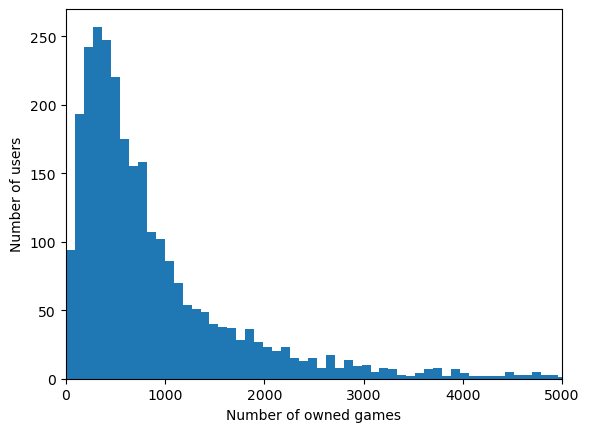

In [603]:
#Histogram of numbers of games owned by users
userCounts = ownedGameInteractionsData['userID'].value_counts();

plt.hist(userCounts.values, bins = 300);

plt.xlim(0,5000)
plt.ylabel('Number of users')
plt.xlabel('Number of owned games')

As anticipated, we get a different distribution. Both distributions look like they could be log-normal, but the owned games distribution's mode is shifted much further to the right.

Now we're gonna check for what precision at k we can reasonably expect for a given train-test split fraction. This is computationally difficult at large numbers of reviews, so I'll need to use a Gaussian distribution above a certain number.

In [676]:
from decimal import *
getcontext().prec = 6

Decimal(336)**Decimal(316).sqrt()

Decimal('8.11367E+44')

In [724]:
from decimal import *
import math

getcontext().prec = 6

kValue = 20
splitFraction = Decimal(0.10)
euler = Decimal(np.exp(1))

#Pick random sample of user's owned game counts to average over
randomUserCounts= userCounts.sample(n=100, random_state=42).values

usersCounted = 0
expectedPrecisionAtK = 0

expected_nTop = 0

for N in randomUserCounts:
    N = N.item()
    print(N)
    
    Nfac = Decimal(factorial(N))
    print('New user!!')
    for nTop in range(1,kValue+1):
        
        prob_nTop = 0
        
        for nC in range(nTop,N+1):
#             print(user[1]-kValue)
#             print(nC-nTop)
            startTime = time.time()
            numNotChosen = N-kValue-(nC-nTop)
            
            if nC > N-kValue and nTop <= nC-(N-kValue):
                prob_nTop += Decimal(math.comb(N,nC))*splitFraction**Decimal(nC)*(1-splitFraction)**Decimal(N - nC)
            
            else:
                prob_nTop += Decimal(math.comb(N-kValue,nC-nTop))*Decimal(math.comb(kValue,nTop))*splitFraction**Decimal(nC)*(1-splitFraction)**Decimal(N - nC)
#                 if nC == nTop:
#                     print('Hypergeometric prob:',Decimal(math.comb(N-kValue,nC-nTop))*Decimal(math.comb(kValue,nTop))/Decimal(math.comb(N,nC)))
                
#             print(time.time()-startTime)
            
#             print(prob_nTop)
        print('prob_nTop:',prob_nTop)
        expected_nTop += nTop*prob_nTop
        
    usersCounted += 1
    
#     print('expected_nTop:',expected_nTop)
    
#     print(expected_nTop)
#     print(kValue)
#     print(usersCounted)
    
    expectedPrecisionAtK = expected_nTop/kValue/usersCounted 
    print('Expected precision at k based on {} randomly sampled users:'.format(usersCounted),expectedPrecisionAtK)

336
New user!!
prob_nTop: 0.270172
prob_nTop: 0.285179
prob_nTop: 0.190120
prob_nTop: 0.0897786
prob_nTop: 0.0319214
prob_nTop: 0.00886701
prob_nTop: 0.00197046
prob_nTop: 0.000355775
prob_nTop: 0.0000527076
prob_nTop: 0.00000644205
prob_nTop: 6.50711E-7
prob_nTop: 5.42260E-8
prob_nTop: 3.70774E-9
prob_nTop: 2.05983E-10
prob_nTop: 9.15494E-12
prob_nTop: 3.17878E-13
prob_nTop: 8.31059E-15
prob_nTop: 1.53901E-16
prob_nTop: 1.80000E-18
prob_nTop: 9.99998E-21
Expected precision at k based on 1 randomly sampled users: 0.0999995
34
New user!!
prob_nTop: 0.270169
prob_nTop: 0.285180
prob_nTop: 0.190121
prob_nTop: 0.0897788
prob_nTop: 0.0319213
prob_nTop: 0.00886704
prob_nTop: 0.00197044
prob_nTop: 0.000355776
prob_nTop: 0.0000527076
prob_nTop: 0.00000644206
prob_nTop: 6.50712E-7
prob_nTop: 5.42261E-8
prob_nTop: 3.70776E-9
prob_nTop: 2.05987E-10
prob_nTop: 9.15495E-12
prob_nTop: 3.17881E-13
prob_nTop: 8.31059E-15
prob_nTop: 1.53900E-16
prob_nTop: 1.80000E-18
prob_nTop: 1.00000E-20
Expected pre

prob_nTop: 0.0000527076
prob_nTop: 0.00000644201
prob_nTop: 6.50715E-7
prob_nTop: 5.42256E-8
prob_nTop: 3.70776E-9
prob_nTop: 2.05985E-10
prob_nTop: 9.15495E-12
prob_nTop: 3.17879E-13
prob_nTop: 8.31062E-15
prob_nTop: 1.53901E-16
prob_nTop: 1.80001E-18
prob_nTop: 9.99999E-21
Expected precision at k based on 17 randomly sampled users: 0.100004
2794
New user!!
prob_nTop: 0.270169
prob_nTop: 0.285174
prob_nTop: 0.190122
prob_nTop: 0.0897785
prob_nTop: 0.0319210
prob_nTop: 0.00886705
prob_nTop: 0.00197047
prob_nTop: 0.000355782
prob_nTop: 0.0000527073
prob_nTop: 0.00000644206
prob_nTop: 6.50708E-7
prob_nTop: 5.42259E-8
prob_nTop: 3.70773E-9
prob_nTop: 2.05985E-10
prob_nTop: 9.15496E-12
prob_nTop: 3.17878E-13
prob_nTop: 8.31060E-15
prob_nTop: 1.53897E-16
prob_nTop: 1.80001E-18
prob_nTop: 9.99999E-21
Expected precision at k based on 18 randomly sampled users: 0.100003
1043
New user!!
prob_nTop: 0.270167
prob_nTop: 0.285180
prob_nTop: 0.190118
prob_nTop: 0.0897785
prob_nTop: 0.0319212
prob_nT

prob_nTop: 0.285178
prob_nTop: 0.190118
prob_nTop: 0.0897789
prob_nTop: 0.0319214
prob_nTop: 0.00886704
prob_nTop: 0.00197045
prob_nTop: 0.000355773
prob_nTop: 0.0000527072
prob_nTop: 0.00000644203
prob_nTop: 6.50710E-7
prob_nTop: 5.42257E-8
prob_nTop: 3.70775E-9
prob_nTop: 2.05988E-10
prob_nTop: 9.15492E-12
prob_nTop: 3.17881E-13
prob_nTop: 8.31060E-15
prob_nTop: 1.53902E-16
prob_nTop: 1.79998E-18
prob_nTop: 1.00000E-20
Expected precision at k based on 34 randomly sampled users: 0.100004
196
New user!!
prob_nTop: 0.270172
prob_nTop: 0.285182
prob_nTop: 0.190119
prob_nTop: 0.0897786
prob_nTop: 0.0319213
prob_nTop: 0.00886703
prob_nTop: 0.00197045
prob_nTop: 0.000355776
prob_nTop: 0.0000527075
prob_nTop: 0.00000644203
prob_nTop: 6.50708E-7
prob_nTop: 5.42259E-8
prob_nTop: 3.70774E-9
prob_nTop: 2.05985E-10
prob_nTop: 9.15497E-12
prob_nTop: 3.17879E-13
prob_nTop: 8.31058E-15
prob_nTop: 1.53898E-16
prob_nTop: 1.79998E-18
prob_nTop: 1.00000E-20
Expected precision at k based on 35 randomly s

prob_nTop: 2.05988E-10
prob_nTop: 9.15493E-12
prob_nTop: 3.17878E-13
prob_nTop: 8.31058E-15
prob_nTop: 1.53901E-16
prob_nTop: 1.80001E-18
prob_nTop: 1.00000E-20
Expected precision at k based on 49 randomly sampled users: 0.100004
1787
New user!!
prob_nTop: 0.270170
prob_nTop: 0.285180
prob_nTop: 0.190118
prob_nTop: 0.0897790
prob_nTop: 0.0319213
prob_nTop: 0.00886707
prob_nTop: 0.00197044
prob_nTop: 0.000355778
prob_nTop: 0.0000527077
prob_nTop: 0.00000644205
prob_nTop: 6.50709E-7
prob_nTop: 5.42254E-8
prob_nTop: 3.70777E-9
prob_nTop: 2.05991E-10
prob_nTop: 9.15498E-12
prob_nTop: 3.17879E-13
prob_nTop: 8.31056E-15
prob_nTop: 1.53901E-16
prob_nTop: 1.79999E-18
prob_nTop: 9.99999E-21
Expected precision at k based on 50 randomly sampled users: 0.100003
675
New user!!
prob_nTop: 0.270170
prob_nTop: 0.285179
prob_nTop: 0.190122
prob_nTop: 0.0897784
prob_nTop: 0.0319213
prob_nTop: 0.00886705
prob_nTop: 0.00197044
prob_nTop: 0.000355772
prob_nTop: 0.0000527074
prob_nTop: 0.00000644207
prob_nT

prob_nTop: 0.0319214
prob_nTop: 0.00886709
prob_nTop: 0.00197045
prob_nTop: 0.000355776
prob_nTop: 0.0000527078
prob_nTop: 0.00000644202
prob_nTop: 6.50712E-7
prob_nTop: 5.42260E-8
prob_nTop: 3.70775E-9
prob_nTop: 2.05987E-10
prob_nTop: 9.15494E-12
prob_nTop: 3.17879E-13
prob_nTop: 8.31057E-15
prob_nTop: 1.53898E-16
prob_nTop: 1.80000E-18
prob_nTop: 1.00000E-20
Expected precision at k based on 65 randomly sampled users: 0.0999908
289
New user!!
prob_nTop: 0.270170
prob_nTop: 0.285180
prob_nTop: 0.190118
prob_nTop: 0.0897787
prob_nTop: 0.0319214
prob_nTop: 0.00886704
prob_nTop: 0.00197044
prob_nTop: 0.000355778
prob_nTop: 0.0000527076
prob_nTop: 0.00000644203
prob_nTop: 6.50708E-7
prob_nTop: 5.42257E-8
prob_nTop: 3.70775E-9
prob_nTop: 2.05987E-10
prob_nTop: 9.15499E-12
prob_nTop: 3.17882E-13
prob_nTop: 8.31059E-15
prob_nTop: 1.53899E-16
prob_nTop: 1.79999E-18
prob_nTop: 9.99997E-21
Expected precision at k based on 66 randomly sampled users: 0.0999902
2651
New user!!
prob_nTop: 0.270174


prob_nTop: 0.285179
prob_nTop: 0.190116
prob_nTop: 0.0897785
prob_nTop: 0.0319214
prob_nTop: 0.00886707
prob_nTop: 0.00197043
prob_nTop: 0.000355778
prob_nTop: 0.0000527076
prob_nTop: 0.00000644203
prob_nTop: 6.50707E-7
prob_nTop: 5.42261E-8
prob_nTop: 3.70773E-9
prob_nTop: 2.05985E-10
prob_nTop: 9.15496E-12
prob_nTop: 3.17879E-13
prob_nTop: 8.31058E-15
prob_nTop: 1.53903E-16
prob_nTop: 1.79999E-18
prob_nTop: 9.99995E-21
Expected precision at k based on 82 randomly sampled users: 0.0999823
191
New user!!
prob_nTop: 0.270169
prob_nTop: 0.285179
prob_nTop: 0.190122
prob_nTop: 0.0897790
prob_nTop: 0.0319212
prob_nTop: 0.00886702
prob_nTop: 0.00197048
prob_nTop: 0.000355777
prob_nTop: 0.0000527076
prob_nTop: 0.00000644203
prob_nTop: 6.50711E-7
prob_nTop: 5.42259E-8
prob_nTop: 3.70776E-9
prob_nTop: 2.05986E-10
prob_nTop: 9.15494E-12
prob_nTop: 3.17879E-13
prob_nTop: 8.31063E-15
prob_nTop: 1.53899E-16
prob_nTop: 1.80001E-18
prob_nTop: 9.99996E-21
Expected precision at k based on 83 randomly 

prob_nTop: 3.17879E-13
prob_nTop: 8.31058E-15
prob_nTop: 1.53900E-16
prob_nTop: 1.80000E-18
prob_nTop: 1.00000E-20
Expected precision at k based on 98 randomly sampled users: 0.0991918
407
New user!!
prob_nTop: 0.270170
prob_nTop: 0.285179
prob_nTop: 0.190117
prob_nTop: 0.0897789
prob_nTop: 0.0319211
prob_nTop: 0.00886701
prob_nTop: 0.00197047
prob_nTop: 0.000355778
prob_nTop: 0.0000527075
prob_nTop: 0.00000644202
prob_nTop: 6.50710E-7
prob_nTop: 5.42258E-8
prob_nTop: 3.70775E-9
prob_nTop: 2.05987E-10
prob_nTop: 9.15495E-12
prob_nTop: 3.17878E-13
prob_nTop: 8.31060E-15
prob_nTop: 1.53900E-16
prob_nTop: 1.80002E-18
prob_nTop: 9.99998E-21
Expected precision at k based on 99 randomly sampled users: 0.0991995
378
New user!!
prob_nTop: 0.270170
prob_nTop: 0.285179
prob_nTop: 0.190120
prob_nTop: 0.0897788
prob_nTop: 0.0319212
prob_nTop: 0.00886701
prob_nTop: 0.00197047
prob_nTop: 0.000355775
prob_nTop: 0.0000527075
prob_nTop: 0.00000644204
prob_nTop: 6.50711E-7
prob_nTop: 5.42261E-8
prob_nTo

I digress. Now I will build the interactions matrix!

In [720]:
Decimal(4**455)

Decimal('8655577598126739396236735036072208081204794589775815018544508256693025219489380097628852320463375366466345287569524796274808382414891999842312830623136802028067007430639699299020497185610570810212749031968132110813561295548441587529128294789399125630804600109428539364737024')

In [664]:
336**326/336**336*0.1**0*0.9**336

2.301920908769688e-41

In [604]:
#Now build the interaction COO matrix
(ownedGamesSparseMatrix, weights) = dataset.build_interactions(((ownedGameInteractionsData['userID'].iloc[index],
                                                             ownedGameInteractionsData['ownedAppIDs'].iloc[index],
                                                             1/inverseWeights.loc[ownedGameInteractionsData['ownedAppIDs'].iloc[index]])
                                                             for index in ownedGameInteractionsData.index))

In [605]:
#Split data into training and test sets
from lightfm.cross_validation import random_train_test_split

ownedGamesSparseMatrix_train, ownedGamesSparseMatrix_nontrain = random_train_test_split(ownedGamesSparseMatrix, random_state=43)

ownedGamesSparseMatrix_validation, ownedGamesSparseMatrix_test = random_train_test_split(ownedGamesSparseMatrix_nontrain, random_state=43,test_percentage=0.5)


In [606]:
print(repr(ownedGamesSparseMatrix))

<2786x54739 sparse matrix of type '<class 'numpy.int32'>'
	with 2926014 stored elements in COOrdinate format>


Now to try optimizing the hyperparameters.

In [379]:
#Hyperparameter optimization
import itertools

import numpy as np

import time

from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k

def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        n = np.random.randint(5,30)
        k = np.random.randint(1,n)
        yield {
            "no_components": np.random.randint(16, 84),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["warp", "warp-kos","bpr"]),
            "k": k,
            "n": n,
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(2, 15),
            "num_epochs": np.random.randint(5, 70),
        }


def random_search(train, trainLogistic, test, testLogistic, num_samples=20, num_threads=4):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    start = time.time()
    
    models = 1
    
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        
        if hyperparams['loss'] == 'logistic':
            model.fit(trainLogistic, epochs=num_epochs, num_threads=num_threads, user_features=None, item_features=tagFeatures)

            score = precision_at_k(model, testLogistic, k=15, train_interactions=trainLogistic, user_features=None, item_features=tagFeatures,num_threads=num_threads).mean()
            scoreAUC = auc_score(model, testLogistic, train_interactions=trainLogistic, user_features=None, item_features=tagFeatures,num_threads=4).mean()

            print('Model {} completed {} seconds after start. Precision at k for this model: {}'.format(models, time.time() - start,np.average(score)))
            print("Validation set AUC score:",scoreAUC)
            
        else:
            model.fit(train, epochs=num_epochs, num_threads=num_threads, user_features=None, item_features=tagFeatures)

            score = precision_at_k(model, test, k=15, train_interactions=train, user_features=None, item_features=tagFeatures,num_threads=num_threads).mean()
            scoreAUC = auc_score(model, test, train_interactions=train, user_features=None, item_features=tagFeatures,num_threads=4).mean()

            print('Model {} completed {} seconds after start. Precision at k for this model: {}'.format(models, time.time() - start,np.average(score)))
            print("Validation set AUC score:",scoreAUC)
    
        hyperparams["num_epochs"] = num_epochs

        print('Hyperparameters for this model:',hyperparams)
        
        yield (score, hyperparams, model)
        
        models += 1


if __name__ == "__main__":
    train = ownedGamesSparseMatrix_train
    test = ownedGamesSparseMatrix_validation
    
    trainLogistic = None
    testLogistic = None

    (score, hyperparams, model) = max(random_search(train, trainLogistic, test, testLogistic, num_threads=4), key=lambda x: x[0])

    print("Best score {} at {}".format(score, hyperparams))

Model 1 completed 12497.905975341797 seconds after start. Precision at k for this model: 0.09186893701553345
Validation set AUC score: 0.9177789
Hyperparameters for this model: {'no_components': 66, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'k': 9, 'n': 12, 'learning_rate': 0.06711781702176897, 'item_alpha': 4.470250757270699e-09, 'user_alpha': 1.821033935951774e-08, 'max_sampled': 12, 'num_epochs': 40}
Model 2 completed 16472.970821619034 seconds after start. Precision at k for this model: 0.05129450187087059
Validation set AUC score: 0.86928076
Hyperparameters for this model: {'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'k': 2, 'n': 20, 'learning_rate': 0.016014155903470186, 'item_alpha': 1.0072773369157902e-08, 'user_alpha': 1.10029520557898e-08, 'max_sampled': 13, 'num_epochs': 47}
Model 3 completed 17375.496042490005 seconds after start. Precision at k for this model: 0.039279937744140625
Validation set AUC score: 0.8673426
Hyperparameters for this mo

Seems like 'bpr' loss fits really slowly. As before, 'warp' is outperforming everything else. So far, the best parameters are:

hyperparameters = {'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 6, 'n': 10, 'learning_rate': 0.05484628899472384, 'item_alpha': 3.350108326463527e-09, 'user_alpha': 2.963937502021301e-09, 'max_sampled': 5},

with 51 training epochs. These are the best hyperparameters set because it yields high AUC scores and precision at k = 20. For this model, those scores are

Validation set precision at k = 20: 0.26456311345100403

Validation set AUC score: 0.967414

The validation set AUC score is excellent. The precision at k = 20 score is low in an absolute sense, but it is actually a little difficult to tell what this says about our model. It could be overfitting, but the AUC score on the validation set is very high and I have checked that the training set AUC score is not much higher (it is also ~0.97). The culprit could just be the sparsity of the validation set. I have chosen the validation set to be a random 10% subset of the overall data. This could result in many users having less than 20 items in their rows, or some of the items that the model recommends them could be in their owned app list but they got randomly sorted into the training set. That would ensure that the maximum achievable precision at k = 20 score on the validation set would be less than 1, with the maximum further from 1 the smaller the size of the subset chosen. One way to actually test this is to force the train-test sets to split in such a way that no user has less than 20 items. However, this could introduce a bias into the model, so I will avoid doing it for now, but perhaps try it later as a check that the model is indeed performing well.

For now, the final check of the model is to score its predictions on the test set.

In [607]:
#Check test set performance
hyperparameters = {'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'warp', 'k': 6, 'n': 10, 'learning_rate': 0.05484628899472384, 'item_alpha': 3.350108326463527e-09, 'user_alpha': 2.963937502021301e-09, 'max_sampled': 5}
model = LightFM(**hyperparameters)
model = model.fit(ownedGamesSparseMatrix_train,
                  user_features=None,
                  item_features=tagFeatures,
                  epochs=51,
                  num_threads=4, verbose=True)

print("Train set AUC score:",auc_score(model, ownedGamesSparseMatrix_train, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
print("Test set AUC score:",auc_score(model, ownedGamesSparseMatrix_test, train_interactions=ownedGamesSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())

print("Train set precision at k:",precision_at_k(model, ownedGamesSparseMatrix_train, k=20, train_interactions=None, user_features=None, item_features=tagFeatures,num_threads=4).mean())
print("Test set precision at k:",precision_at_k(model, ownedGamesSparseMatrix_test, k=20, train_interactions=ownedGamesSparseMatrix_train, user_features=None, item_features=tagFeatures,num_threads=4).mean())


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Train set AUC score: 0.9776567
Test set AUC score: 0.97084844
Train set precision at k: 0.697631
Test set precision at k: 0.247307


The model seems to be doing quite well! The AUC scores are very high and do not indicate overfitting. The precision at k = 20 scores are lower, and lower still for the test set. But as I explained above, this could just be a reflection of the matrix sparsity rather than overfitting, and the high AUC scores support this explanation.

Now, for fun, I'll make a script to generate recommendations for random users in the dataset. This will also serve as a check that the model is not getting a high AUC score by just recommending the same popular items to everyone.

In [547]:
#Recommend some games (that the user does not already own) for some number of users
import random

user = 0
numUsers = 10
iteration = 0

while user < numUsers:
    
    #Retrieve mapping between user/item IDs and LightFM internal indices
    userIDMap = dataset.mapping()[0]
    itemIDMap = dataset.mapping()[2]

    #Pick a random user and get list of games he owns
    userX = random.choice(list(dataset.mapping()[0].values()))
    userX_ID = list(userIDMap.keys())[list(userIDMap.values()).index(userX)]
    userXGames = ownedGames[ownedGames['userID'] == userX_ID]['ownedAppIDs'].values[0]
    
    authorID = list(userIDMap.keys())[userX]
    
    print(userX)
    
    scores = np.array(model.predict(userX,list(itemIDMap.values()), item_features=tagFeatures, user_features=None))

    top5GamesBool = pd.Series(scores).sort_values(ascending=False).index
    
    top5List = []
    successCount = 0
    
    for top5Game in top5GamesBool:

        try:
            gameID = list(itemIDMap.keys())[list(itemIDMap.values()).index(top5Game)]
            game = rawGames[rawGames['appId'] == int(gameID)]['name'].values[0]
            
            if gameID not in userXGames:
                top5List.append(game)
                successCount += 1
        except IndexError:
            #print('App {} does not exist in Steam Store anymore.'.format(int(list(itemIDMap.keys())[list(itemIDMap.values()).index(top5Game)])))
            pass
            
        if successCount == 5:
            break
    print(top5List)

    user += 1

560
['Half-Life 2: Lost Coast', 'Tomb Raider', 'Portal', 'Half-Life 2', 'Counter-Strike: Source']
811
["Mirror's Edge\x99", 'Defence Alliance 2', 'AudioSurf', 'Hacknet', 'PAYDAY 2']
928
['Transpose', 'Fantasynth One', 'Creed: Rise to Glory\x99', 'Chivalry: Medieval Warfare', 'POSTAL']
745
['Torchlight II', 'Minion Masters', 'Divinity: Original Sin 2 - Definitive Edition', 'Factorio', 'Rocket League®']
2223
['War Thunder', 'Defence Alliance 2', 'The Lab', '7 Days to Die', 'Alien Swarm']
485
['Orcs Must Die! 2', 'Borderlands Game of the Year Enhanced', 'Scanner Sombre', 'Darwinia', 'Borderlands Game of the Year']
454
['Counter-Strike: Source', 'ARK: Survival Evolved', 'Warhammer: Vermintide 2', 'Half-Life 2: Deathmatch', 'Counter-Strike: Global Offensive']
2613
['Gone Home', 'Syberia II', 'Layers of Fear', 'Amnesia: The Dark Descent', "Mirror's Edge\x99"]
743
['STRIDER / ', 'QUAKE II Mission Pack: Ground Zero', 'BioShock\x99 Remastered', 'DOOM II', 'Ultimate Doom']
2710
["Sid Meier's Civ

The recommendations look pretty good. Users, for the most part, are recommended different items. Now I'll try the model on myself, and see if it recommends me items that I will like! This will serve as a good check of the model's "face validity."

In [618]:
#Recommend some new games for myself

#Retrieve mapping between user/item IDs and LightFM internal indices
userIDMap = dataset.mapping()[0]
itemIDMap = dataset.mapping()[2]

intersectionList = []

#Add my Steam information
for userX, name in zip([2782,2783,2784,2785],['Me','Jayson','Mary','Micah']):
    userX_ID = list(userIDMap.keys())[list(userIDMap.values()).index(userX)]
    userXGames = ownedGames[ownedGames['userID'] == userX_ID]['ownedAppIDs'].values[0]

    authorID = list(userIDMap.keys())[userX]

    print(name)

    scores = np.array(model.predict(userX,list(itemIDMap.values()), item_features=tagFeatures, user_features=None))

    top5GamesBool = pd.Series(scores).sort_values(ascending=False).index

    top5List = []
    successCount = 0


    for top5Game in top5GamesBool:

        try:
            gameID = list(itemIDMap.keys())[list(itemIDMap.values()).index(top5Game)]
            game = rawGames[rawGames['appId'] == int(gameID)]['name'].values[0]


            if gameID not in userXGames:
                top5List.append(game)
                successCount += 1

        except IndexError:
            #print('App {} does not exist in Steam Store anymore.'.format(int(list(itemIDMap.keys())[list(itemIDMap.values()).index(top5Game)])))
            pass

        if successCount == 50:
            break

    print(top5List,'\n')
    
    #Add to list of games recommended to all of us
    if intersectionList == []:
        intersectionList.append(top5List)
        intersectionList = intersectionList[0]
        
    else:
        intersectionList = intersection(intersectionList,top5List)
        
print('Games that are recommended to all of us:',intersectionList)

Me
['Path of Exile', 'Lost Ark', 'Torchlight II', 'Borderlands 2', 'Terraria', 'Team Fortress Classic', "Don't Starve Together", 'Monster Hunter: World', 'Destiny 2', 'Dota 2', 'Half-Life', 'Deathmatch Classic', 'Warframe', 'Half-Life 2: Deathmatch', 'Titan Quest Anniversary Edition', 'Dying Light', 'Conan Exiles', 'Counter-Strike', 'Borderlands Game of the Year', 'Grim Dawn', 'Project Zomboid', 'New World', 'Half-Life Deathmatch: Source', 'Warhammer: End Times - Vermintide', 'Dungeon Defenders', 'Counter-Strike: Source', 'Magicka', 'PlanetSide 2 - Test', 'Darkest Dungeon®', 'Borderlands Game of the Year Enhanced', "No Man's Sky", 'Half-Life 2: Lost Coast', 'Left 4 Dead', 'The Elder Scrolls® Online', 'Counter-Strike: Global Offensive', 'Ricochet', 'Half-Life 2', 'RIFT', 'Torchlight', 'Half-Life: Opposing Force', 'Alien Swarm', 'V Rising', 'PAYDAY 2', 'PUBG: BATTLEGROUNDS', 'Half-Life: Blue Shift', 'Saints Row: The Third', 'Middle-earth\x99: Shadow of Mordor\x99', 'Borderlands: The Pre-

For most of the entries in my recommendation list, they are games I either already want or would be interested to try. Only a few are things that seem unappealing to me. I should also note that I believe the model is recommending a bunch of Half-Life titles to me because I own Team Fortress 2 and not Half-Life, although most people in the dataset own both (probably because Steam sells a bunch of Valve bundles that package them together).

I also made predictions for my friends and family. The model recommended them games that were either already on their wishlist or things they were unaware of but were eager to try. They have since added many of the games listed here to their wishlists! Only a few of the recommended games seemed uninteresting to them.

This simple check looks good. I think the model is performing well!

In [551]:
list(dataset.mapping()[0].values())[-1]

2782